In [1]:
# Install PyTorch
!pip install -U torch==1.8.1+cu101 torchvision==0.9.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.7 MB 10 kB/s 
     |████████████████████████████████| 17.3 MB 80 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.8.1+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.8.1+cu101 which is incompatible.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.

In [2]:
!rm -rf tcc
!git clone https://github.com/matheussn/tcc.git
%cd tcc

Cloning into 'tcc'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (393/393), done.
remote: Compressing objects: 100% (268/268), done.
remote: Total 393 (delta 183), reused 310 (delta 103), pack-reused 0
Receiving objects: 100% (393/393), 49.42 MiB | 24.92 MiB/s, done.
Resolving deltas: 100% (183/183), done.
/content/tcc


In [3]:
!rm -rf mmsegmentation
!git clone -b v0.20.2 https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6379, done.
remote: Counting objects: 100% (882/882), done.
remote: Compressing objects: 100% (482/482), done.
remote: Total 6379 (delta 524), reused 594 (delta 392), pack-reused 5497
Receiving objects: 100% (6379/6379), 12.76 MiB | 21.74 MiB/s, done.
Resolving deltas: 100% (4593/4593), done.
Note: checking out '991b0512b9f4835275957e4c4896b5f4c4696eac'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

/content/tcc/mmsegmentation
Obtaining file:///content/tcc/mmsegmentation
  Running setup.py develop for mmsegmentation


In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.datasets import build_dataset
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.apis import set_random_seed, train_segmentor
from mmseg.models import build_segmentor
print(mmseg.__version__)

import mmcv
from mmcv import Config

import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

1.8.1+cu101 True
0.20.2


In [5]:
!rm -rf ToTrain/
!unzip ../../ToTrain.zip

Archive:  ../../ToTrain.zip
   creating: ToTrain/
   creating: ToTrain/annotations/
  inflating: ToTrain/annotations/image020-roi1.tif  
  inflating: ToTrain/annotations/image008-roi1.tif  
  inflating: ToTrain/annotations/image032-roi1.tif  
  inflating: ToTrain/annotations/image019-roi2.tif  
  inflating: ToTrain/annotations/image019-roi5.tif  
  inflating: ToTrain/annotations/image058-roi5.tif  
  inflating: ToTrain/annotations/image038-roi4.tif  
  inflating: ToTrain/annotations/image058-roi1.tif  
  inflating: ToTrain/annotations/image021-roi3.tif  
  inflating: ToTrain/annotations/image006-roi2.tif  
  inflating: ToTrain/annotations/image021-roi6.tif  
  inflating: ToTrain/annotations/image038-roi1.tif  
  inflating: ToTrain/annotations/image003-2-roi3.tif  
  inflating: ToTrain/annotations/image038-roi3.tif  
  inflating: ToTrain/annotations/image039-roi3.tif  
  inflating: ToTrain/annotations/image017-roi1.tif  
  inflating: ToTrain/annotations/image004-roi2.tif  
  inflating: 

In [6]:
data_root = 'ToTrain'
img_dir = 'images'
ann_dir = 'annotations'

In [7]:
classes = ('bg', 'cell')
palette = [[0, 0, 0], [255, 255, 255]]

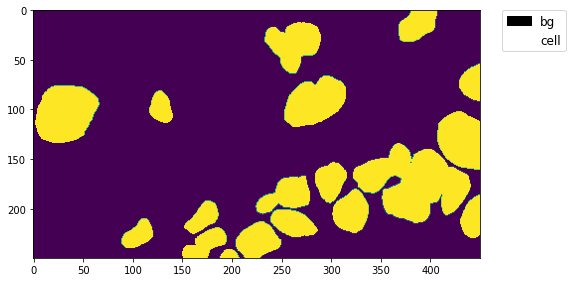

In [8]:
# Let's take a look at the segmentation map we got

img = Image.open('ToTrain/annotations/image003-2-roi1.tif')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [9]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.tif')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [10]:
@DATASETS.register_module()
class DysplasiaDataSet(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.tif', seg_map_suffix='.tif', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [11]:
cfg = Config.fromfile('../models/pspnet.py')

In [12]:
cfg.runner.max_epochs = 100
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'DysplasiaDataSet'
data_root = 'ToTrain'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (256, 256)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(256, 256), cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(256, 256), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(256, 256),
        flip=False,
        transforms=[
            dict(type='Resize

In [13]:
datasets = [build_dataset(cfg.data.train)]

2022-03-05 13:45:13,313 - mmseg - INFO - Loaded 96 images


In [14]:
# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

In [15]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-03-05 13:45:16,436 - mmseg - INFO - Loaded 24 images
2022-03-05 13:45:16,438 - mmseg - INFO - Start running, host: root@2648b115a1b6, work_dir: /content/tcc/mmsegmentation/work_dirs/psp
2022-03-05 13:45:16,443 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.6 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:45:36,671 - mmseg - INFO - per class results:
2022-03-05 13:45:36,677 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.68 | 100.0 |
|  cell |  0.0  |  0.0  |
+-------+-------+-------+
2022-03-05 13:45:36,678 - mmseg - INFO - Summary:
2022-03-05 13:45:36,681 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 67.61 | 40.34 | 50.0 |
+-------+-------+------+
2022-03-05 13:45:36,692 - mmseg - INFO - Epoch(val) [1][24]	aAcc: 0.6761, mDice: 0.4034, mAcc: 0.5000, Dice.bg: 0.8068, Dice.cell: 0.0000, Acc.bg: 1.0000, Acc.cell: 0.0000
2022-03-05 13:45:54,209 - mmseg - INFO - Epoch [2][12/12]	lr: 9.911e-03, eta: 0:28:43, time: 1.449, data_time: 0.188, memory: 3768, decode.loss_ce: 0.5112, decode.acc_seg: 50.2138, aux.loss_ce: 0.2015, aux.acc_seg: 50.7528, loss: 0.7127


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:45:56,331 - mmseg - INFO - per class results:
2022-03-05 13:45:56,334 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.68 | 100.0 |
|  cell |  0.0  |  0.0  |
+-------+-------+-------+
2022-03-05 13:45:56,337 - mmseg - INFO - Summary:
2022-03-05 13:45:56,341 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 67.61 | 40.34 | 50.0 |
+-------+-------+------+
2022-03-05 13:45:56,344 - mmseg - INFO - Epoch(val) [2][24]	aAcc: 0.6761, mDice: 0.4034, mAcc: 0.5000, Dice.bg: 0.8068, Dice.cell: 0.0000, Acc.bg: 1.0000, Acc.cell: 0.0000
2022-03-05 13:46:13,878 - mmseg - INFO - Epoch [3][12/12]	lr: 9.822e-03, eta: 0:28:19, time: 1.450, data_time: 0.182, memory: 3768, decode.loss_ce: 0.4932, decode.acc_seg: 51.9257, aux.loss_ce: 0.1943, aux.acc_seg: 52.8595, loss: 0.6876


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:46:16,002 - mmseg - INFO - per class results:
2022-03-05 13:46:16,006 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 77.53 | 90.82 |
|  cell | 14.45 |  9.28 |
+-------+-------+-------+
2022-03-05 13:46:16,008 - mmseg - INFO - Summary:
2022-03-05 13:46:16,010 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 64.41 | 45.99 | 50.05 |
+-------+-------+-------+
2022-03-05 13:46:16,015 - mmseg - INFO - Epoch(val) [3][24]	aAcc: 0.6441, mDice: 0.4599, mAcc: 0.5005, Dice.bg: 0.7753, Dice.cell: 0.1445, Acc.bg: 0.9082, Acc.cell: 0.0928
2022-03-05 13:46:33,694 - mmseg - INFO - Epoch [4][12/12]	lr: 9.732e-03, eta: 0:28:02, time: 1.462, data_time: 0.188, memory: 3768, decode.loss_ce: 0.4767, decode.acc_seg: 52.7643, aux.loss_ce: 0.1877, aux.acc_seg: 53.2200, loss: 0.6645


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:46:35,812 - mmseg - INFO - per class results:
2022-03-05 13:46:35,816 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 78.43 | 86.52 |
|  cell | 36.72 | 28.82 |
+-------+-------+-------+
2022-03-05 13:46:35,817 - mmseg - INFO - Summary:
2022-03-05 13:46:35,820 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 67.83 | 57.57 | 57.67 |
+-------+-------+-------+
2022-03-05 13:46:35,824 - mmseg - INFO - Epoch(val) [4][24]	aAcc: 0.6783, mDice: 0.5757, mAcc: 0.5767, Dice.bg: 0.7843, Dice.cell: 0.3672, Acc.bg: 0.8652, Acc.cell: 0.2882
2022-03-05 13:46:53,476 - mmseg - INFO - Epoch [5][12/12]	lr: 9.643e-03, eta: 0:27:44, time: 1.460, data_time: 0.188, memory: 3768, decode.loss_ce: 0.4543, decode.acc_seg: 55.4761, aux.loss_ce: 0.1784, aux.acc_seg: 56.3762, loss: 0.6328


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:46:55,606 - mmseg - INFO - per class results:
2022-03-05 13:46:55,613 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 78.59 | 79.98 |
|  cell | 52.76 | 50.81 |
+-------+-------+-------+
2022-03-05 13:46:55,615 - mmseg - INFO - Summary:
2022-03-05 13:46:55,618 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 70.53 | 65.67 | 65.39 |
+-------+-------+-------+
2022-03-05 13:46:55,620 - mmseg - INFO - Epoch(val) [5][24]	aAcc: 0.7053, mDice: 0.6567, mAcc: 0.6539, Dice.bg: 0.7859, Dice.cell: 0.5276, Acc.bg: 0.7998, Acc.cell: 0.5081
2022-03-05 13:47:13,232 - mmseg - INFO - Epoch [6][12/12]	lr: 9.553e-03, eta: 0:27:26, time: 1.456, data_time: 0.184, memory: 3768, decode.loss_ce: 0.4194, decode.acc_seg: 55.3696, aux.loss_ce: 0.1701, aux.acc_seg: 55.3695, loss: 0.5896


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:47:15,364 - mmseg - INFO - per class results:
2022-03-05 13:47:15,368 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.84 | 94.19 |
|  cell | 42.95 | 30.66 |
+-------+-------+-------+
2022-03-05 13:47:15,370 - mmseg - INFO - Summary:
2022-03-05 13:47:15,374 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 73.62 | 62.89 | 62.43 |
+-------+-------+-------+
2022-03-05 13:47:15,378 - mmseg - INFO - Epoch(val) [6][24]	aAcc: 0.7362, mDice: 0.6289, mAcc: 0.6243, Dice.bg: 0.8284, Dice.cell: 0.4295, Acc.bg: 0.9419, Acc.cell: 0.3066
2022-03-05 13:47:33,045 - mmseg - INFO - Epoch [7][12/12]	lr: 9.464e-03, eta: 0:27:09, time: 1.461, data_time: 0.188, memory: 3768, decode.loss_ce: 0.4138, decode.acc_seg: 57.4067, aux.loss_ce: 0.1642, aux.acc_seg: 57.2433, loss: 0.5780


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:47:35,183 - mmseg - INFO - per class results:
2022-03-05 13:47:35,185 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.69 | 84.46 |
|  cell | 57.48 | 53.42 |
+-------+-------+-------+
2022-03-05 13:47:35,188 - mmseg - INFO - Summary:
2022-03-05 13:47:35,191 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 74.41 | 69.59 | 68.94 |
+-------+-------+-------+
2022-03-05 13:47:35,195 - mmseg - INFO - Epoch(val) [7][24]	aAcc: 0.7441, mDice: 0.6959, mAcc: 0.6894, Dice.bg: 0.8169, Dice.cell: 0.5748, Acc.bg: 0.8446, Acc.cell: 0.5342
2022-03-05 13:47:52,880 - mmseg - INFO - Epoch [8][12/12]	lr: 9.374e-03, eta: 0:26:52, time: 1.462, data_time: 0.188, memory: 3768, decode.loss_ce: 0.3962, decode.acc_seg: 58.6083, aux.loss_ce: 0.1593, aux.acc_seg: 58.4910, loss: 0.5555


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:47:55,004 - mmseg - INFO - per class results:
2022-03-05 13:47:55,009 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.18 | 76.54 |
|  cell | 63.94 | 70.01 |
+-------+-------+-------+
2022-03-05 13:47:55,010 - mmseg - INFO - Summary:
2022-03-05 13:47:55,021 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 74.42 | 72.06 | 73.28 |
+-------+-------+-------+
2022-03-05 13:47:55,023 - mmseg - INFO - Epoch(val) [8][24]	aAcc: 0.7442, mDice: 0.7206, mAcc: 0.7328, Dice.bg: 0.8018, Dice.cell: 0.6394, Acc.bg: 0.7654, Acc.cell: 0.7001
2022-03-05 13:48:12,730 - mmseg - INFO - Epoch [9][12/12]	lr: 9.284e-03, eta: 0:26:35, time: 1.464, data_time: 0.191, memory: 3768, decode.loss_ce: 0.4152, decode.acc_seg: 59.2980, aux.loss_ce: 0.1674, aux.acc_seg: 59.0018, loss: 0.5826


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:48:14,858 - mmseg - INFO - per class results:
2022-03-05 13:48:14,861 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.39 | 88.76 |
|  cell | 57.35 | 49.63 |
+-------+-------+-------+
2022-03-05 13:48:14,862 - mmseg - INFO - Summary:
2022-03-05 13:48:14,866 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 76.09 | 70.37 | 69.2 |
+-------+-------+------+
2022-03-05 13:48:14,871 - mmseg - INFO - Epoch(val) [9][24]	aAcc: 0.7609, mDice: 0.7037, mAcc: 0.6920, Dice.bg: 0.8339, Dice.cell: 0.5735, Acc.bg: 0.8876, Acc.cell: 0.4963
2022-03-05 13:48:32,470 - mmseg - INFO - Epoch [10][12/12]	lr: 9.194e-03, eta: 0:26:17, time: 1.455, data_time: 0.184, memory: 3768, decode.loss_ce: 0.3859, decode.acc_seg: 57.7258, aux.loss_ce: 0.1538, aux.acc_seg: 57.5875, loss: 0.5397
2022-03-05 13:48:32,473 - mmseg - INFO - Saving checkpoint at 10 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:48:36,951 - mmseg - INFO - per class results:
2022-03-05 13:48:36,954 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.06 | 88.15 |
|  cell | 61.15 | 54.94 |
+-------+-------+-------+
2022-03-05 13:48:36,958 - mmseg - INFO - Summary:
2022-03-05 13:48:36,965 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.39 |  72.6 | 71.54 |
+-------+-------+-------+
2022-03-05 13:48:36,968 - mmseg - INFO - Epoch(val) [10][24]	aAcc: 0.7739, mDice: 0.7260, mAcc: 0.7154, Dice.bg: 0.8406, Dice.cell: 0.6115, Acc.bg: 0.8815, Acc.cell: 0.5494
2022-03-05 13:48:54,645 - mmseg - INFO - Epoch [11][12/12]	lr: 9.104e-03, eta: 0:25:59, time: 1.462, data_time: 0.189, memory: 3768, decode.loss_ce: 0.4023, decode.acc_seg: 62.4859, aux.loss_ce: 0.1625, aux.acc_seg: 62.2968, loss: 0.5648


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:48:56,774 - mmseg - INFO - per class results:
2022-03-05 13:48:56,777 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.14 | 85.63 |
|  cell | 61.34 | 57.51 |
+-------+-------+-------+
2022-03-05 13:48:56,778 - mmseg - INFO - Summary:
2022-03-05 13:48:56,781 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 76.52 | 72.24 | 71.57 |
+-------+-------+-------+
2022-03-05 13:48:56,792 - mmseg - INFO - Epoch(val) [11][24]	aAcc: 0.7652, mDice: 0.7224, mAcc: 0.7157, Dice.bg: 0.8314, Dice.cell: 0.6134, Acc.bg: 0.8563, Acc.cell: 0.5751
2022-03-05 13:49:14,444 - mmseg - INFO - Epoch [12][12/12]	lr: 9.014e-03, eta: 0:25:42, time: 1.460, data_time: 0.185, memory: 3768, decode.loss_ce: 0.3703, decode.acc_seg: 56.4826, aux.loss_ce: 0.1492, aux.acc_seg: 56.2529, loss: 0.5195


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:49:16,573 - mmseg - INFO - per class results:
2022-03-05 13:49:16,575 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.91 | 78.89 |
|  cell | 66.23 | 71.32 |
+-------+-------+-------+
2022-03-05 13:49:16,581 - mmseg - INFO - Summary:
2022-03-05 13:49:16,583 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 76.44 | 74.07 | 75.11 |
+-------+-------+-------+
2022-03-05 13:49:16,585 - mmseg - INFO - Epoch(val) [12][24]	aAcc: 0.7644, mDice: 0.7407, mAcc: 0.7511, Dice.bg: 0.8191, Dice.cell: 0.6623, Acc.bg: 0.7889, Acc.cell: 0.7132
2022-03-05 13:49:34,219 - mmseg - INFO - Epoch [13][12/12]	lr: 8.924e-03, eta: 0:25:24, time: 1.458, data_time: 0.188, memory: 3768, decode.loss_ce: 0.3865, decode.acc_seg: 60.5959, aux.loss_ce: 0.1546, aux.acc_seg: 60.6043, loss: 0.5411


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:49:36,354 - mmseg - INFO - per class results:
2022-03-05 13:49:36,356 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.07 | 78.61 |
|  cell | 67.05 | 72.95 |
+-------+-------+-------+
2022-03-05 13:49:36,359 - mmseg - INFO - Summary:
2022-03-05 13:49:36,367 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 76.78 | 74.56 | 75.78 |
+-------+-------+-------+
2022-03-05 13:49:36,373 - mmseg - INFO - Epoch(val) [13][24]	aAcc: 0.7678, mDice: 0.7456, mAcc: 0.7578, Dice.bg: 0.8207, Dice.cell: 0.6705, Acc.bg: 0.7861, Acc.cell: 0.7295
2022-03-05 13:49:53,960 - mmseg - INFO - Epoch [14][12/12]	lr: 8.834e-03, eta: 0:25:06, time: 1.454, data_time: 0.180, memory: 3768, decode.loss_ce: 0.3748, decode.acc_seg: 58.5759, aux.loss_ce: 0.1503, aux.acc_seg: 58.6247, loss: 0.5251


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:49:56,094 - mmseg - INFO - per class results:
2022-03-05 13:49:56,098 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.28 | 85.64 |
|  cell |  65.5 |  63.3 |
+-------+-------+-------+
2022-03-05 13:49:56,099 - mmseg - INFO - Summary:
2022-03-05 13:49:56,102 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.41 | 74.89 | 74.47 |
+-------+-------+-------+
2022-03-05 13:49:56,107 - mmseg - INFO - Epoch(val) [14][24]	aAcc: 0.7841, mDice: 0.7489, mAcc: 0.7447, Dice.bg: 0.8428, Dice.cell: 0.6550, Acc.bg: 0.8564, Acc.cell: 0.6330
2022-03-05 13:50:13,733 - mmseg - INFO - Epoch [15][12/12]	lr: 8.743e-03, eta: 0:24:48, time: 1.458, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3591, decode.acc_seg: 58.9163, aux.loss_ce: 0.1448, aux.acc_seg: 58.6272, loss: 0.5040


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:50:15,848 - mmseg - INFO - per class results:
2022-03-05 13:50:15,851 - mmseg - INFO - 
+-------+-------+------+
| Class |  Dice | Acc  |
+-------+-------+------+
|   bg  | 84.97 | 88.3 |
|  cell | 64.48 | 59.2 |
+-------+-------+------+
2022-03-05 13:50:15,854 - mmseg - INFO - Summary:
2022-03-05 13:50:15,855 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.87 | 74.72 | 73.75 |
+-------+-------+-------+
2022-03-05 13:50:15,864 - mmseg - INFO - Epoch(val) [15][24]	aAcc: 0.7887, mDice: 0.7472, mAcc: 0.7375, Dice.bg: 0.8497, Dice.cell: 0.6448, Acc.bg: 0.8830, Acc.cell: 0.5920
2022-03-05 13:50:33,461 - mmseg - INFO - Epoch [16][12/12]	lr: 8.653e-03, eta: 0:24:31, time: 1.455, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3646, decode.acc_seg: 61.0781, aux.loss_ce: 0.1468, aux.acc_seg: 60.9019, loss: 0.5114


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:50:35,599 - mmseg - INFO - per class results:
2022-03-05 13:50:35,602 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.87 | 87.86 |
|  cell | 64.72 | 59.96 |
+-------+-------+-------+
2022-03-05 13:50:35,605 - mmseg - INFO - Summary:
2022-03-05 13:50:35,611 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.82 | 74.79 | 73.91 |
+-------+-------+-------+
2022-03-05 13:50:35,615 - mmseg - INFO - Epoch(val) [16][24]	aAcc: 0.7882, mDice: 0.7479, mAcc: 0.7391, Dice.bg: 0.8487, Dice.cell: 0.6472, Acc.bg: 0.8786, Acc.cell: 0.5996
2022-03-05 13:50:53,272 - mmseg - INFO - Epoch [17][12/12]	lr: 8.562e-03, eta: 0:24:13, time: 1.460, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3563, decode.acc_seg: 59.2442, aux.loss_ce: 0.1444, aux.acc_seg: 59.0388, loss: 0.5007


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:50:55,407 - mmseg - INFO - per class results:
2022-03-05 13:50:55,409 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.84 | 85.37 |
|  cell | 67.73 | 66.85 |
+-------+-------+-------+
2022-03-05 13:50:55,412 - mmseg - INFO - Summary:
2022-03-05 13:50:55,415 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.37 | 76.29 | 76.11 |
+-------+-------+-------+
2022-03-05 13:50:55,421 - mmseg - INFO - Epoch(val) [17][24]	aAcc: 0.7937, mDice: 0.7629, mAcc: 0.7611, Dice.bg: 0.8484, Dice.cell: 0.6773, Acc.bg: 0.8537, Acc.cell: 0.6685
2022-03-05 13:51:13,087 - mmseg - INFO - Epoch [18][12/12]	lr: 8.472e-03, eta: 0:23:56, time: 1.461, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3582, decode.acc_seg: 62.0551, aux.loss_ce: 0.1456, aux.acc_seg: 61.8139, loss: 0.5039


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:51:15,228 - mmseg - INFO - per class results:
2022-03-05 13:51:15,229 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.61 | 78.65 |
|  cell | 68.58 | 75.44 |
+-------+-------+-------+
2022-03-05 13:51:15,232 - mmseg - INFO - Summary:
2022-03-05 13:51:15,238 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.61 | 75.59 | 77.04 |
+-------+-------+-------+
2022-03-05 13:51:15,240 - mmseg - INFO - Epoch(val) [18][24]	aAcc: 0.7761, mDice: 0.7559, mAcc: 0.7704, Dice.bg: 0.8261, Dice.cell: 0.6858, Acc.bg: 0.7865, Acc.cell: 0.7544
2022-03-05 13:51:32,925 - mmseg - INFO - Epoch [19][12/12]	lr: 8.381e-03, eta: 0:23:38, time: 1.462, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3341, decode.acc_seg: 60.9757, aux.loss_ce: 0.1377, aux.acc_seg: 60.3987, loss: 0.4719


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:51:35,045 - mmseg - INFO - per class results:
2022-03-05 13:51:35,049 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.25 | 80.45 |
|  cell | 68.42 | 73.23 |
+-------+-------+-------+
2022-03-05 13:51:35,050 - mmseg - INFO - Summary:
2022-03-05 13:51:35,053 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.11 | 75.84 | 76.84 |
+-------+-------+-------+
2022-03-05 13:51:35,065 - mmseg - INFO - Epoch(val) [19][24]	aAcc: 0.7811, mDice: 0.7584, mAcc: 0.7684, Dice.bg: 0.8325, Dice.cell: 0.6842, Acc.bg: 0.8045, Acc.cell: 0.7323
2022-03-05 13:51:52,646 - mmseg - INFO - Epoch [20][12/12]	lr: 8.290e-03, eta: 0:23:20, time: 1.454, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3543, decode.acc_seg: 62.0962, aux.loss_ce: 0.1451, aux.acc_seg: 61.5569, loss: 0.4994
2022-03-05 13:51:52,649 - mmseg - INFO - Saving checkpoint at 20 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:51:56,440 - mmseg - INFO - per class results:
2022-03-05 13:51:56,443 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.28 | 80.48 |
|  cell | 68.47 | 73.28 |
+-------+-------+-------+
2022-03-05 13:51:56,445 - mmseg - INFO - Summary:
2022-03-05 13:51:56,449 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.15 | 75.88 | 76.88 |
+-------+-------+-------+
2022-03-05 13:51:56,455 - mmseg - INFO - Epoch(val) [20][24]	aAcc: 0.7815, mDice: 0.7588, mAcc: 0.7688, Dice.bg: 0.8328, Dice.cell: 0.6847, Acc.bg: 0.8048, Acc.cell: 0.7328
2022-03-05 13:52:14,157 - mmseg - INFO - Epoch [21][12/12]	lr: 8.199e-03, eta: 0:23:03, time: 1.464, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3547, decode.acc_seg: 60.2353, aux.loss_ce: 0.1416, aux.acc_seg: 60.1774, loss: 0.4962


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:52:16,316 - mmseg - INFO - per class results:
2022-03-05 13:52:16,324 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.52 | 86.51 |
|  cell | 68.68 | 67.02 |
+-------+-------+-------+
2022-03-05 13:52:16,325 - mmseg - INFO - Summary:
2022-03-05 13:52:16,327 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 80.2 |  77.1 | 76.77 |
+------+-------+-------+
2022-03-05 13:52:16,330 - mmseg - INFO - Epoch(val) [21][24]	aAcc: 0.8020, mDice: 0.7710, mAcc: 0.7677, Dice.bg: 0.8552, Dice.cell: 0.6868, Acc.bg: 0.8651, Acc.cell: 0.6702
2022-03-05 13:52:34,027 - mmseg - INFO - Epoch [22][12/12]	lr: 8.108e-03, eta: 0:22:46, time: 1.464, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3301, decode.acc_seg: 57.5929, aux.loss_ce: 0.1329, aux.acc_seg: 57.5784, loss: 0.4629


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:52:36,153 - mmseg - INFO - per class results:
2022-03-05 13:52:36,157 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.13 | 81.78 |
|  cell | 69.59 | 73.66 |
+-------+-------+-------+
2022-03-05 13:52:36,159 - mmseg - INFO - Summary:
2022-03-05 13:52:36,165 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.15 | 76.86 | 77.72 |
+-------+-------+-------+
2022-03-05 13:52:36,167 - mmseg - INFO - Epoch(val) [22][24]	aAcc: 0.7915, mDice: 0.7686, mAcc: 0.7772, Dice.bg: 0.8413, Dice.cell: 0.6959, Acc.bg: 0.8178, Acc.cell: 0.7366
2022-03-05 13:52:53,789 - mmseg - INFO - Epoch [23][12/12]	lr: 8.016e-03, eta: 0:22:28, time: 1.457, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3446, decode.acc_seg: 62.5124, aux.loss_ce: 0.1393, aux.acc_seg: 62.3505, loss: 0.4839


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:52:55,949 - mmseg - INFO - per class results:
2022-03-05 13:52:55,953 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.05 | 78.23 |
|  cell | 70.26 | 78.77 |
+-------+-------+-------+
2022-03-05 13:52:55,956 - mmseg - INFO - Summary:
2022-03-05 13:52:55,962 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 78.41 | 76.66 | 78.5 |
+-------+-------+------+
2022-03-05 13:52:55,964 - mmseg - INFO - Epoch(val) [23][24]	aAcc: 0.7841, mDice: 0.7666, mAcc: 0.7850, Dice.bg: 0.8305, Dice.cell: 0.7026, Acc.bg: 0.7823, Acc.cell: 0.7877
2022-03-05 13:53:13,666 - mmseg - INFO - Epoch [24][12/12]	lr: 7.925e-03, eta: 0:22:11, time: 1.464, data_time: 0.192, memory: 3768, decode.loss_ce: 0.3194, decode.acc_seg: 59.8696, aux.loss_ce: 0.1329, aux.acc_seg: 59.1857, loss: 0.4523


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:53:15,795 - mmseg - INFO - per class results:
2022-03-05 13:53:15,799 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  82.6 |  77.3 |
|  cell | 70.03 | 79.41 |
+-------+-------+-------+
2022-03-05 13:53:15,802 - mmseg - INFO - Summary:
2022-03-05 13:53:15,810 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.98 | 76.31 | 78.35 |
+-------+-------+-------+
2022-03-05 13:53:15,811 - mmseg - INFO - Epoch(val) [24][24]	aAcc: 0.7798, mDice: 0.7631, mAcc: 0.7835, Dice.bg: 0.8260, Dice.cell: 0.7003, Acc.bg: 0.7730, Acc.cell: 0.7941
2022-03-05 13:53:33,537 - mmseg - INFO - Epoch [25][12/12]	lr: 7.833e-03, eta: 0:21:54, time: 1.466, data_time: 0.188, memory: 3768, decode.loss_ce: 0.3232, decode.acc_seg: 61.6773, aux.loss_ce: 0.1339, aux.acc_seg: 61.0504, loss: 0.4570


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:53:35,678 - mmseg - INFO - per class results:
2022-03-05 13:53:35,681 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.85 | 80.55 |
|  cell | 70.06 | 75.81 |
+-------+-------+-------+
2022-03-05 13:53:35,685 - mmseg - INFO - Summary:
2022-03-05 13:53:35,688 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.02 | 76.96 | 78.18 |
+-------+-------+-------+
2022-03-05 13:53:35,692 - mmseg - INFO - Epoch(val) [25][24]	aAcc: 0.7902, mDice: 0.7696, mAcc: 0.7818, Dice.bg: 0.8385, Dice.cell: 0.7006, Acc.bg: 0.8055, Acc.cell: 0.7581
2022-03-05 13:53:53,363 - mmseg - INFO - Epoch [26][12/12]	lr: 7.742e-03, eta: 0:21:36, time: 1.461, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3361, decode.acc_seg: 59.6145, aux.loss_ce: 0.1361, aux.acc_seg: 59.3144, loss: 0.4723


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:53:55,515 - mmseg - INFO - per class results:
2022-03-05 13:53:55,519 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.34 | 84.64 |
|  cell | 70.15 | 71.35 |
+-------+-------+-------+
2022-03-05 13:53:55,521 - mmseg - INFO - Summary:
2022-03-05 13:53:55,524 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.34 | 77.74 | 77.99 |
+-------+-------+-------+
2022-03-05 13:53:55,532 - mmseg - INFO - Epoch(val) [26][24]	aAcc: 0.8034, mDice: 0.7774, mAcc: 0.7799, Dice.bg: 0.8534, Dice.cell: 0.7015, Acc.bg: 0.8464, Acc.cell: 0.7135
2022-03-05 13:54:13,218 - mmseg - INFO - Epoch [27][12/12]	lr: 7.650e-03, eta: 0:21:19, time: 1.462, data_time: 0.184, memory: 3768, decode.loss_ce: 0.3339, decode.acc_seg: 63.4542, aux.loss_ce: 0.1372, aux.acc_seg: 62.9999, loss: 0.4711


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:54:15,355 - mmseg - INFO - per class results:
2022-03-05 13:54:15,357 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.73 | 81.86 |
|  cell | 71.23 | 76.27 |
+-------+-------+-------+
2022-03-05 13:54:15,365 - mmseg - INFO - Summary:
2022-03-05 13:54:15,367 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.05 | 77.98 | 79.06 |
+-------+-------+-------+
2022-03-05 13:54:15,371 - mmseg - INFO - Epoch(val) [27][24]	aAcc: 0.8005, mDice: 0.7798, mAcc: 0.7906, Dice.bg: 0.8473, Dice.cell: 0.7123, Acc.bg: 0.8186, Acc.cell: 0.7627
2022-03-05 13:54:32,966 - mmseg - INFO - Epoch [28][12/12]	lr: 7.558e-03, eta: 0:21:01, time: 1.455, data_time: 0.179, memory: 3768, decode.loss_ce: 0.3199, decode.acc_seg: 60.8006, aux.loss_ce: 0.1321, aux.acc_seg: 60.3103, loss: 0.4520


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:54:35,074 - mmseg - INFO - per class results:
2022-03-05 13:54:35,079 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.92 | 75.71 |
|  cell | 69.88 | 80.92 |
+-------+-------+-------+
2022-03-05 13:54:35,081 - mmseg - INFO - Summary:
2022-03-05 13:54:35,083 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 77.4 |  75.9 | 78.32 |
+------+-------+-------+
2022-03-05 13:54:35,093 - mmseg - INFO - Epoch(val) [28][24]	aAcc: 0.7740, mDice: 0.7590, mAcc: 0.7832, Dice.bg: 0.8192, Dice.cell: 0.6988, Acc.bg: 0.7571, Acc.cell: 0.8092
2022-03-05 13:54:52,746 - mmseg - INFO - Epoch [29][12/12]	lr: 7.466e-03, eta: 0:20:43, time: 1.460, data_time: 0.192, memory: 3768, decode.loss_ce: 0.3134, decode.acc_seg: 60.3946, aux.loss_ce: 0.1289, aux.acc_seg: 60.0488, loss: 0.4423


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:54:54,870 - mmseg - INFO - per class results:
2022-03-05 13:54:54,872 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.32 | 76.31 |
|  cell | 70.32 | 81.05 |
+-------+-------+-------+
2022-03-05 13:54:54,874 - mmseg - INFO - Summary:
2022-03-05 13:54:54,876 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.84 | 76.32 | 78.68 |
+-------+-------+-------+
2022-03-05 13:54:54,886 - mmseg - INFO - Epoch(val) [29][24]	aAcc: 0.7784, mDice: 0.7632, mAcc: 0.7868, Dice.bg: 0.8232, Dice.cell: 0.7032, Acc.bg: 0.7631, Acc.cell: 0.8105
2022-03-05 13:55:12,542 - mmseg - INFO - Epoch [30][12/12]	lr: 7.374e-03, eta: 0:20:26, time: 1.460, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3461, decode.acc_seg: 64.5323, aux.loss_ce: 0.1415, aux.acc_seg: 64.0915, loss: 0.4876
2022-03-05 13:55:12,545 - mmseg - INFO - Saving checkpoint at 30 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:55:16,551 - mmseg - INFO - per class results:
2022-03-05 13:55:16,554 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.03 | 73.17 |
|  cell | 70.27 |  84.5 |
+-------+-------+-------+
2022-03-05 13:55:16,557 - mmseg - INFO - Summary:
2022-03-05 13:55:16,559 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 76.84 | 75.65 | 78.83 |
+-------+-------+-------+
2022-03-05 13:55:16,568 - mmseg - INFO - Epoch(val) [30][24]	aAcc: 0.7684, mDice: 0.7565, mAcc: 0.7883, Dice.bg: 0.8103, Dice.cell: 0.7027, Acc.bg: 0.7317, Acc.cell: 0.8450
2022-03-05 13:55:34,325 - mmseg - INFO - Epoch [31][12/12]	lr: 7.282e-03, eta: 0:20:09, time: 1.468, data_time: 0.185, memory: 3768, decode.loss_ce: 0.3474, decode.acc_seg: 65.7027, aux.loss_ce: 0.1423, aux.acc_seg: 65.2682, loss: 0.4897


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:55:36,440 - mmseg - INFO - per class results:
2022-03-05 13:55:36,444 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.53 | 81.08 |
|  cell | 71.46 | 77.55 |
+-------+-------+-------+
2022-03-05 13:55:36,447 - mmseg - INFO - Summary:
2022-03-05 13:55:36,449 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.93 | 77.99 | 79.31 |
+-------+-------+-------+
2022-03-05 13:55:36,458 - mmseg - INFO - Epoch(val) [31][24]	aAcc: 0.7993, mDice: 0.7799, mAcc: 0.7931, Dice.bg: 0.8453, Dice.cell: 0.7146, Acc.bg: 0.8108, Acc.cell: 0.7755
2022-03-05 13:55:54,344 - mmseg - INFO - Epoch [32][12/12]	lr: 7.189e-03, eta: 0:19:52, time: 1.479, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3174, decode.acc_seg: 63.6371, aux.loss_ce: 0.1310, aux.acc_seg: 63.0766, loss: 0.4485


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:55:56,533 - mmseg - INFO - per class results:
2022-03-05 13:55:56,537 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.64 | 81.33 |
|  cell | 71.52 | 77.36 |
+-------+-------+-------+
2022-03-05 13:55:56,540 - mmseg - INFO - Summary:
2022-03-05 13:55:56,542 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.04 | 78.08 | 79.34 |
+-------+-------+-------+
2022-03-05 13:55:56,552 - mmseg - INFO - Epoch(val) [32][24]	aAcc: 0.8004, mDice: 0.7808, mAcc: 0.7934, Dice.bg: 0.8464, Dice.cell: 0.7152, Acc.bg: 0.8133, Acc.cell: 0.7736
2022-03-05 13:56:14,469 - mmseg - INFO - Epoch [33][12/12]	lr: 7.097e-03, eta: 0:19:35, time: 1.482, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3288, decode.acc_seg: 65.2515, aux.loss_ce: 0.1336, aux.acc_seg: 65.0364, loss: 0.4624


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:56:16,665 - mmseg - INFO - per class results:
2022-03-05 13:56:16,667 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.33 | 73.71 |
|  cell | 70.46 | 84.24 |
+-------+-------+-------+
2022-03-05 13:56:16,670 - mmseg - INFO - Summary:
2022-03-05 13:56:16,674 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.12 |  75.9 | 78.98 |
+-------+-------+-------+
2022-03-05 13:56:16,684 - mmseg - INFO - Epoch(val) [33][24]	aAcc: 0.7712, mDice: 0.7590, mAcc: 0.7898, Dice.bg: 0.8133, Dice.cell: 0.7046, Acc.bg: 0.7371, Acc.cell: 0.8424
2022-03-05 13:56:34,548 - mmseg - INFO - Epoch [34][12/12]	lr: 7.004e-03, eta: 0:19:17, time: 1.477, data_time: 0.184, memory: 3768, decode.loss_ce: 0.3294, decode.acc_seg: 65.8558, aux.loss_ce: 0.1341, aux.acc_seg: 65.4560, loss: 0.4634


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:56:36,751 - mmseg - INFO - per class results:
2022-03-05 13:56:36,758 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.14 | 82.29 |
|  cell | 71.96 | 76.98 |
+-------+-------+-------+
2022-03-05 13:56:36,762 - mmseg - INFO - Summary:
2022-03-05 13:56:36,763 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.57 | 78.55 | 79.64 |
+-------+-------+-------+
2022-03-05 13:56:36,765 - mmseg - INFO - Epoch(val) [34][24]	aAcc: 0.8057, mDice: 0.7855, mAcc: 0.7964, Dice.bg: 0.8514, Dice.cell: 0.7196, Acc.bg: 0.8229, Acc.cell: 0.7698
2022-03-05 13:56:54,681 - mmseg - INFO - Epoch [35][12/12]	lr: 6.911e-03, eta: 0:19:00, time: 1.482, data_time: 0.184, memory: 3768, decode.loss_ce: 0.3129, decode.acc_seg: 61.4906, aux.loss_ce: 0.1292, aux.acc_seg: 61.0724, loss: 0.4421


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:56:56,885 - mmseg - INFO - per class results:
2022-03-05 13:56:56,888 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.69 | 76.11 |
|  cell | 71.48 | 83.36 |
+-------+-------+-------+
2022-03-05 13:56:56,891 - mmseg - INFO - Summary:
2022-03-05 13:56:56,894 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.46 | 77.09 | 79.73 |
+-------+-------+-------+
2022-03-05 13:56:56,896 - mmseg - INFO - Epoch(val) [35][24]	aAcc: 0.7846, mDice: 0.7709, mAcc: 0.7973, Dice.bg: 0.8269, Dice.cell: 0.7148, Acc.bg: 0.7611, Acc.cell: 0.8336
2022-03-05 13:57:14,929 - mmseg - INFO - Epoch [36][12/12]	lr: 6.818e-03, eta: 0:18:43, time: 1.491, data_time: 0.192, memory: 3768, decode.loss_ce: 0.3446, decode.acc_seg: 66.6993, aux.loss_ce: 0.1420, aux.acc_seg: 66.1071, loss: 0.4866


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:57:17,116 - mmseg - INFO - per class results:
2022-03-05 13:57:17,119 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  82.7 | 76.57 |
|  cell | 71.05 | 82.06 |
+-------+-------+-------+
2022-03-05 13:57:17,122 - mmseg - INFO - Summary:
2022-03-05 13:57:17,123 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.35 | 76.88 | 79.31 |
+-------+-------+-------+
2022-03-05 13:57:17,125 - mmseg - INFO - Epoch(val) [36][24]	aAcc: 0.7835, mDice: 0.7688, mAcc: 0.7931, Dice.bg: 0.8270, Dice.cell: 0.7105, Acc.bg: 0.7657, Acc.cell: 0.8206
2022-03-05 13:57:35,074 - mmseg - INFO - Epoch [37][12/12]	lr: 6.725e-03, eta: 0:18:26, time: 1.484, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3319, decode.acc_seg: 62.8745, aux.loss_ce: 0.1362, aux.acc_seg: 62.4390, loss: 0.4681


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:57:37,283 - mmseg - INFO - per class results:
2022-03-05 13:57:37,287 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.83 |  81.9 |
|  cell | 71.47 | 76.62 |
+-------+-------+-------+
2022-03-05 13:57:37,290 - mmseg - INFO - Summary:
2022-03-05 13:57:37,291 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.19 | 78.15 | 79.26 |
+-------+-------+-------+
2022-03-05 13:57:37,297 - mmseg - INFO - Epoch(val) [37][24]	aAcc: 0.8019, mDice: 0.7815, mAcc: 0.7926, Dice.bg: 0.8483, Dice.cell: 0.7147, Acc.bg: 0.8190, Acc.cell: 0.7662
2022-03-05 13:57:55,246 - mmseg - INFO - Epoch [38][12/12]	lr: 6.632e-03, eta: 0:18:09, time: 1.484, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3179, decode.acc_seg: 64.3510, aux.loss_ce: 0.1298, aux.acc_seg: 63.8830, loss: 0.4477


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:57:57,473 - mmseg - INFO - per class results:
2022-03-05 13:57:57,475 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.02 | 76.94 |
|  cell | 71.51 | 82.44 |
+-------+-------+-------+
2022-03-05 13:57:57,477 - mmseg - INFO - Summary:
2022-03-05 13:57:57,481 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.72 | 77.26 | 79.69 |
+-------+-------+-------+
2022-03-05 13:57:57,486 - mmseg - INFO - Epoch(val) [38][24]	aAcc: 0.7872, mDice: 0.7726, mAcc: 0.7969, Dice.bg: 0.8302, Dice.cell: 0.7151, Acc.bg: 0.7694, Acc.cell: 0.8244
2022-03-05 13:58:15,513 - mmseg - INFO - Epoch [39][12/12]	lr: 6.539e-03, eta: 0:17:52, time: 1.491, data_time: 0.188, memory: 3768, decode.loss_ce: 0.3132, decode.acc_seg: 62.4630, aux.loss_ce: 0.1275, aux.acc_seg: 62.1180, loss: 0.4407


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:58:17,729 - mmseg - INFO - per class results:
2022-03-05 13:58:17,731 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.32 | 75.74 |
|  cell | 70.89 | 82.72 |
+-------+-------+-------+
2022-03-05 13:58:17,734 - mmseg - INFO - Summary:
2022-03-05 13:58:17,736 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 78.0 | 76.61 | 79.23 |
+------+-------+-------+
2022-03-05 13:58:17,747 - mmseg - INFO - Epoch(val) [39][24]	aAcc: 0.7800, mDice: 0.7661, mAcc: 0.7923, Dice.bg: 0.8232, Dice.cell: 0.7089, Acc.bg: 0.7574, Acc.cell: 0.8272
2022-03-05 13:58:35,711 - mmseg - INFO - Epoch [40][12/12]	lr: 6.445e-03, eta: 0:17:35, time: 1.485, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3195, decode.acc_seg: 66.6841, aux.loss_ce: 0.1316, aux.acc_seg: 66.1901, loss: 0.4511
2022-03-05 13:58:35,713 - mmseg - INFO - Saving checkpoint at 40 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:58:39,642 - mmseg - INFO - per class results:
2022-03-05 13:58:39,645 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.87 |  76.4 |
|  cell | 71.66 | 83.35 |
+-------+-------+-------+
2022-03-05 13:58:39,656 - mmseg - INFO - Summary:
2022-03-05 13:58:39,660 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.65 | 77.27 | 79.87 |
+-------+-------+-------+
2022-03-05 13:58:39,663 - mmseg - INFO - Epoch(val) [40][24]	aAcc: 0.7865, mDice: 0.7727, mAcc: 0.7987, Dice.bg: 0.8287, Dice.cell: 0.7166, Acc.bg: 0.7640, Acc.cell: 0.8335
2022-03-05 13:58:57,561 - mmseg - INFO - Epoch [41][12/12]	lr: 6.351e-03, eta: 0:17:17, time: 1.480, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3141, decode.acc_seg: 62.8929, aux.loss_ce: 0.1286, aux.acc_seg: 62.5715, loss: 0.4427


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:58:59,750 - mmseg - INFO - per class results:
2022-03-05 13:58:59,755 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.63 | 83.52 |
|  cell | 72.17 | 75.89 |
+-------+-------+-------+
2022-03-05 13:58:59,758 - mmseg - INFO - Summary:
2022-03-05 13:58:59,760 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 81.05 |  78.9 | 79.7 |
+-------+-------+------+
2022-03-05 13:58:59,765 - mmseg - INFO - Epoch(val) [41][24]	aAcc: 0.8105, mDice: 0.7890, mAcc: 0.7970, Dice.bg: 0.8563, Dice.cell: 0.7217, Acc.bg: 0.8352, Acc.cell: 0.7589
2022-03-05 13:59:17,558 - mmseg - INFO - Epoch [42][12/12]	lr: 6.257e-03, eta: 0:17:00, time: 1.471, data_time: 0.183, memory: 3768, decode.loss_ce: 0.3286, decode.acc_seg: 66.3984, aux.loss_ce: 0.1352, aux.acc_seg: 65.9867, loss: 0.4638


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:59:19,731 - mmseg - INFO - per class results:
2022-03-05 13:59:19,734 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.44 | 79.51 |
|  cell | 72.74 | 81.61 |
+-------+-------+-------+
2022-03-05 13:59:19,736 - mmseg - INFO - Summary:
2022-03-05 13:59:19,740 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.19 | 78.59 | 80.56 |
+-------+-------+-------+
2022-03-05 13:59:19,741 - mmseg - INFO - Epoch(val) [42][24]	aAcc: 0.8019, mDice: 0.7859, mAcc: 0.8056, Dice.bg: 0.8444, Dice.cell: 0.7274, Acc.bg: 0.7951, Acc.cell: 0.8161
2022-03-05 13:59:37,606 - mmseg - INFO - Epoch [43][12/12]	lr: 6.163e-03, eta: 0:16:42, time: 1.477, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3165, decode.acc_seg: 66.9955, aux.loss_ce: 0.1312, aux.acc_seg: 66.3448, loss: 0.4477


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:59:39,780 - mmseg - INFO - per class results:
2022-03-05 13:59:39,782 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.21 | 74.79 |
|  cell | 71.58 | 85.06 |
+-------+-------+-------+
2022-03-05 13:59:39,787 - mmseg - INFO - Summary:
2022-03-05 13:59:39,792 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.12 | 76.89 | 79.93 |
+-------+-------+-------+
2022-03-05 13:59:39,799 - mmseg - INFO - Epoch(val) [43][24]	aAcc: 0.7812, mDice: 0.7689, mAcc: 0.7993, Dice.bg: 0.8221, Dice.cell: 0.7158, Acc.bg: 0.7479, Acc.cell: 0.8506
2022-03-05 13:59:57,709 - mmseg - INFO - Epoch [44][12/12]	lr: 6.069e-03, eta: 0:16:25, time: 1.481, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3079, decode.acc_seg: 63.0910, aux.loss_ce: 0.1262, aux.acc_seg: 62.6175, loss: 0.4341


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 13:59:59,896 - mmseg - INFO - per class results:
2022-03-05 13:59:59,900 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.47 | 79.74 |
|  cell | 72.59 | 81.07 |
+-------+-------+-------+
2022-03-05 13:59:59,904 - mmseg - INFO - Summary:
2022-03-05 13:59:59,906 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.17 | 78.53 | 80.41 |
+-------+-------+-------+
2022-03-05 13:59:59,908 - mmseg - INFO - Epoch(val) [44][24]	aAcc: 0.8017, mDice: 0.7853, mAcc: 0.8041, Dice.bg: 0.8447, Dice.cell: 0.7259, Acc.bg: 0.7974, Acc.cell: 0.8107
2022-03-05 14:00:17,812 - mmseg - INFO - Epoch [45][12/12]	lr: 5.975e-03, eta: 0:16:08, time: 1.481, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2951, decode.acc_seg: 63.4257, aux.loss_ce: 0.1236, aux.acc_seg: 62.6513, loss: 0.4187


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:00:19,992 - mmseg - INFO - per class results:
2022-03-05 14:00:19,995 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.59 | 83.15 |
|  cell | 72.43 | 76.75 |
+-------+-------+-------+
2022-03-05 14:00:19,997 - mmseg - INFO - Summary:
2022-03-05 14:00:19,999 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.08 | 79.01 | 79.95 |
+-------+-------+-------+
2022-03-05 14:00:20,009 - mmseg - INFO - Epoch(val) [45][24]	aAcc: 0.8108, mDice: 0.7901, mAcc: 0.7995, Dice.bg: 0.8559, Dice.cell: 0.7243, Acc.bg: 0.8315, Acc.cell: 0.7675
2022-03-05 14:00:37,992 - mmseg - INFO - Epoch [46][12/12]	lr: 5.880e-03, eta: 0:15:50, time: 1.487, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3371, decode.acc_seg: 67.9508, aux.loss_ce: 0.1367, aux.acc_seg: 67.6585, loss: 0.4738


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:00:40,187 - mmseg - INFO - per class results:
2022-03-05 14:00:40,189 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.91 | 81.22 |
|  cell | 72.38 | 78.95 |
+-------+-------+-------+
2022-03-05 14:00:40,192 - mmseg - INFO - Summary:
2022-03-05 14:00:40,203 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.48 | 78.64 | 80.08 |
+-------+-------+-------+
2022-03-05 14:00:40,204 - mmseg - INFO - Epoch(val) [46][24]	aAcc: 0.8048, mDice: 0.7864, mAcc: 0.8008, Dice.bg: 0.8491, Dice.cell: 0.7238, Acc.bg: 0.8122, Acc.cell: 0.7895
2022-03-05 14:00:58,132 - mmseg - INFO - Epoch [47][12/12]	lr: 5.786e-03, eta: 0:15:33, time: 1.483, data_time: 0.184, memory: 3768, decode.loss_ce: 0.2953, decode.acc_seg: 60.5963, aux.loss_ce: 0.1227, aux.acc_seg: 60.0425, loss: 0.4181


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:01:00,330 - mmseg - INFO - per class results:
2022-03-05 14:01:00,335 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.27 | 81.82 |
|  cell |  72.8 | 78.95 |
+-------+-------+-------+
2022-03-05 14:01:00,337 - mmseg - INFO - Summary:
2022-03-05 14:01:00,338 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.89 | 79.03 | 80.38 |
+-------+-------+-------+
2022-03-05 14:01:00,347 - mmseg - INFO - Epoch(val) [47][24]	aAcc: 0.8089, mDice: 0.7903, mAcc: 0.8038, Dice.bg: 0.8527, Dice.cell: 0.7280, Acc.bg: 0.8182, Acc.cell: 0.7895
2022-03-05 14:01:18,252 - mmseg - INFO - Epoch [48][12/12]	lr: 5.691e-03, eta: 0:15:16, time: 1.481, data_time: 0.188, memory: 3768, decode.loss_ce: 0.3273, decode.acc_seg: 68.3092, aux.loss_ce: 0.1345, aux.acc_seg: 67.9896, loss: 0.4618


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:01:20,444 - mmseg - INFO - per class results:
2022-03-05 14:01:20,448 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.84 | 71.67 |
|  cell | 71.33 | 88.22 |
+-------+-------+-------+
2022-03-05 14:01:20,451 - mmseg - INFO - Summary:
2022-03-05 14:01:20,457 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.03 | 76.09 | 79.95 |
+-------+-------+-------+
2022-03-05 14:01:20,461 - mmseg - INFO - Epoch(val) [48][24]	aAcc: 0.7703, mDice: 0.7609, mAcc: 0.7995, Dice.bg: 0.8084, Dice.cell: 0.7133, Acc.bg: 0.7167, Acc.cell: 0.8822
2022-03-05 14:01:38,502 - mmseg - INFO - Epoch [49][12/12]	lr: 5.596e-03, eta: 0:14:58, time: 1.492, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3085, decode.acc_seg: 63.8031, aux.loss_ce: 0.1271, aux.acc_seg: 63.4363, loss: 0.4355


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:01:40,698 - mmseg - INFO - per class results:
2022-03-05 14:01:40,701 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.69 | 75.52 |
|  cell | 72.05 | 85.09 |
+-------+-------+-------+
2022-03-05 14:01:40,704 - mmseg - INFO - Summary:
2022-03-05 14:01:40,708 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 78.62 | 77.37 | 80.3 |
+-------+-------+------+
2022-03-05 14:01:40,711 - mmseg - INFO - Epoch(val) [49][24]	aAcc: 0.7862, mDice: 0.7737, mAcc: 0.8030, Dice.bg: 0.8269, Dice.cell: 0.7205, Acc.bg: 0.7552, Acc.cell: 0.8509
2022-03-05 14:01:58,615 - mmseg - INFO - Epoch [50][12/12]	lr: 5.501e-03, eta: 0:14:41, time: 1.481, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3017, decode.acc_seg: 64.0516, aux.loss_ce: 0.1256, aux.acc_seg: 63.3453, loss: 0.4273
2022-03-05 14:01:58,621 - mmseg - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:02:02,458 - mmseg - INFO - per class results:
2022-03-05 14:02:02,462 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.96 | 81.14 |
|  cell |  72.6 | 79.43 |
+-------+-------+-------+
2022-03-05 14:02:02,465 - mmseg - INFO - Summary:
2022-03-05 14:02:02,470 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.58 | 78.78 | 80.28 |
+-------+-------+-------+
2022-03-05 14:02:02,473 - mmseg - INFO - Epoch(val) [50][24]	aAcc: 0.8058, mDice: 0.7878, mAcc: 0.8028, Dice.bg: 0.8496, Dice.cell: 0.7260, Acc.bg: 0.8114, Acc.cell: 0.7943
2022-03-05 14:02:20,397 - mmseg - INFO - Epoch [51][12/12]	lr: 5.405e-03, eta: 0:14:23, time: 1.482, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2904, decode.acc_seg: 61.9306, aux.loss_ce: 0.1196, aux.acc_seg: 61.3454, loss: 0.4100


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:02:22,582 - mmseg - INFO - per class results:
2022-03-05 14:02:22,588 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.97 | 80.81 |
|  cell | 72.92 | 80.35 |
+-------+-------+-------+
2022-03-05 14:02:22,588 - mmseg - INFO - Summary:
2022-03-05 14:02:22,595 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.67 | 78.94 | 80.58 |
+-------+-------+-------+
2022-03-05 14:02:22,598 - mmseg - INFO - Epoch(val) [51][24]	aAcc: 0.8067, mDice: 0.7894, mAcc: 0.8058, Dice.bg: 0.8497, Dice.cell: 0.7292, Acc.bg: 0.8081, Acc.cell: 0.8035
2022-03-05 14:02:40,531 - mmseg - INFO - Epoch [52][12/12]	lr: 5.310e-03, eta: 0:14:06, time: 1.483, data_time: 0.184, memory: 3768, decode.loss_ce: 0.3257, decode.acc_seg: 70.4849, aux.loss_ce: 0.1340, aux.acc_seg: 69.9604, loss: 0.4597


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:02:42,701 - mmseg - INFO - per class results:
2022-03-05 14:02:42,706 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.92 |  73.8 |
|  cell | 71.82 | 86.67 |
+-------+-------+-------+
2022-03-05 14:02:42,707 - mmseg - INFO - Summary:
2022-03-05 14:02:42,710 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.97 | 76.87 | 80.24 |
+-------+-------+-------+
2022-03-05 14:02:42,719 - mmseg - INFO - Epoch(val) [52][24]	aAcc: 0.7797, mDice: 0.7687, mAcc: 0.8024, Dice.bg: 0.8192, Dice.cell: 0.7182, Acc.bg: 0.7380, Acc.cell: 0.8667
2022-03-05 14:03:00,667 - mmseg - INFO - Epoch [53][12/12]	lr: 5.214e-03, eta: 0:13:48, time: 1.484, data_time: 0.185, memory: 3768, decode.loss_ce: 0.2985, decode.acc_seg: 62.9102, aux.loss_ce: 0.1225, aux.acc_seg: 62.3886, loss: 0.4210


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:03:02,858 - mmseg - INFO - per class results:
2022-03-05 14:03:02,863 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.76 | 77.92 |
|  cell | 72.48 | 83.05 |
+-------+-------+-------+
2022-03-05 14:03:02,865 - mmseg - INFO - Summary:
2022-03-05 14:03:02,867 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.58 | 78.12 | 80.48 |
+-------+-------+-------+
2022-03-05 14:03:02,872 - mmseg - INFO - Epoch(val) [53][24]	aAcc: 0.7958, mDice: 0.7812, mAcc: 0.8048, Dice.bg: 0.8376, Dice.cell: 0.7248, Acc.bg: 0.7792, Acc.cell: 0.8305
2022-03-05 14:03:20,759 - mmseg - INFO - Epoch [54][12/12]	lr: 5.118e-03, eta: 0:13:31, time: 1.479, data_time: 0.179, memory: 3768, decode.loss_ce: 0.2933, decode.acc_seg: 63.8148, aux.loss_ce: 0.1205, aux.acc_seg: 63.4390, loss: 0.4139


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:03:22,958 - mmseg - INFO - per class results:
2022-03-05 14:03:22,963 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.77 | 75.73 |
|  cell | 72.05 | 84.83 |
+-------+-------+-------+
2022-03-05 14:03:22,965 - mmseg - INFO - Summary:
2022-03-05 14:03:22,967 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.68 | 77.41 | 80.28 |
+-------+-------+-------+
2022-03-05 14:03:22,975 - mmseg - INFO - Epoch(val) [54][24]	aAcc: 0.7868, mDice: 0.7741, mAcc: 0.8028, Dice.bg: 0.8277, Dice.cell: 0.7205, Acc.bg: 0.7573, Acc.cell: 0.8483
2022-03-05 14:03:40,906 - mmseg - INFO - Epoch [55][12/12]	lr: 5.022e-03, eta: 0:13:13, time: 1.483, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2936, decode.acc_seg: 65.3857, aux.loss_ce: 0.1210, aux.acc_seg: 64.9915, loss: 0.4146


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:03:43,067 - mmseg - INFO - per class results:
2022-03-05 14:03:43,072 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.16 | 78.47 |
|  cell |  73.0 | 83.31 |
+-------+-------+-------+
2022-03-05 14:03:43,074 - mmseg - INFO - Summary:
2022-03-05 14:03:43,076 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.04 | 78.58 | 80.89 |
+-------+-------+-------+
2022-03-05 14:03:43,088 - mmseg - INFO - Epoch(val) [55][24]	aAcc: 0.8004, mDice: 0.7858, mAcc: 0.8089, Dice.bg: 0.8416, Dice.cell: 0.7300, Acc.bg: 0.7847, Acc.cell: 0.8331
2022-03-05 14:04:00,999 - mmseg - INFO - Epoch [56][12/12]	lr: 4.925e-03, eta: 0:12:56, time: 1.481, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2947, decode.acc_seg: 62.7059, aux.loss_ce: 0.1218, aux.acc_seg: 62.2150, loss: 0.4165


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:04:03,191 - mmseg - INFO - per class results:
2022-03-05 14:04:03,195 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.02 | 76.02 |
|  cell | 72.39 | 85.13 |
+-------+-------+-------+
2022-03-05 14:04:03,197 - mmseg - INFO - Summary:
2022-03-05 14:04:03,203 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.97 |  77.7 | 80.57 |
+-------+-------+-------+
2022-03-05 14:04:03,207 - mmseg - INFO - Epoch(val) [56][24]	aAcc: 0.7897, mDice: 0.7770, mAcc: 0.8057, Dice.bg: 0.8302, Dice.cell: 0.7239, Acc.bg: 0.7602, Acc.cell: 0.8513
2022-03-05 14:04:21,247 - mmseg - INFO - Epoch [57][12/12]	lr: 4.829e-03, eta: 0:12:38, time: 1.492, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3193, decode.acc_seg: 68.5261, aux.loss_ce: 0.1317, aux.acc_seg: 67.9242, loss: 0.4509


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:04:23,462 - mmseg - INFO - per class results:
2022-03-05 14:04:23,464 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.97 |  75.6 |
|  cell | 72.67 | 86.15 |
+-------+-------+-------+
2022-03-05 14:04:23,467 - mmseg - INFO - Summary:
2022-03-05 14:04:23,469 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.02 | 77.82 | 80.87 |
+-------+-------+-------+
2022-03-05 14:04:23,473 - mmseg - INFO - Epoch(val) [57][24]	aAcc: 0.7902, mDice: 0.7782, mAcc: 0.8087, Dice.bg: 0.8297, Dice.cell: 0.7267, Acc.bg: 0.7560, Acc.cell: 0.8615
2022-03-05 14:04:41,397 - mmseg - INFO - Epoch [58][12/12]	lr: 4.732e-03, eta: 0:12:21, time: 1.482, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2946, decode.acc_seg: 64.0052, aux.loss_ce: 0.1234, aux.acc_seg: 63.2774, loss: 0.4180


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:04:43,564 - mmseg - INFO - per class results:
2022-03-05 14:04:43,566 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.64 | 85.08 |
|  cell | 73.61 | 76.37 |
+-------+-------+-------+
2022-03-05 14:04:43,576 - mmseg - INFO - Summary:
2022-03-05 14:04:43,578 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.26 | 80.12 | 80.73 |
+-------+-------+-------+
2022-03-05 14:04:43,581 - mmseg - INFO - Epoch(val) [58][24]	aAcc: 0.8226, mDice: 0.8012, mAcc: 0.8073, Dice.bg: 0.8664, Dice.cell: 0.7361, Acc.bg: 0.8508, Acc.cell: 0.7637
2022-03-05 14:05:01,513 - mmseg - INFO - Epoch [59][12/12]	lr: 4.635e-03, eta: 0:12:03, time: 1.483, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3143, decode.acc_seg: 65.9435, aux.loss_ce: 0.1284, aux.acc_seg: 65.5959, loss: 0.4426


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:05:03,672 - mmseg - INFO - per class results:
2022-03-05 14:05:03,680 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.65 | 77.57 |
|  cell | 72.51 |  83.5 |
+-------+-------+-------+
2022-03-05 14:05:03,682 - mmseg - INFO - Summary:
2022-03-05 14:05:03,683 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.49 | 78.08 | 80.54 |
+-------+-------+-------+
2022-03-05 14:05:03,687 - mmseg - INFO - Epoch(val) [59][24]	aAcc: 0.7949, mDice: 0.7808, mAcc: 0.8054, Dice.bg: 0.8365, Dice.cell: 0.7251, Acc.bg: 0.7757, Acc.cell: 0.8350
2022-03-05 14:05:21,610 - mmseg - INFO - Epoch [60][12/12]	lr: 4.538e-03, eta: 0:11:46, time: 1.482, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2848, decode.acc_seg: 60.3927, aux.loss_ce: 0.1167, aux.acc_seg: 59.9755, loss: 0.4015
2022-03-05 14:05:21,614 - mmseg - INFO - Saving checkpoint at 60 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:05:25,475 - mmseg - INFO - per class results:
2022-03-05 14:05:25,477 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  84.1 | 78.13 |
|  cell | 73.14 | 83.98 |
+-------+-------+-------+
2022-03-05 14:05:25,486 - mmseg - INFO - Summary:
2022-03-05 14:05:25,488 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.02 | 78.62 | 81.05 |
+-------+-------+-------+
2022-03-05 14:05:25,493 - mmseg - INFO - Epoch(val) [60][24]	aAcc: 0.8002, mDice: 0.7862, mAcc: 0.8105, Dice.bg: 0.8410, Dice.cell: 0.7314, Acc.bg: 0.7813, Acc.cell: 0.8398
2022-03-05 14:05:43,485 - mmseg - INFO - Epoch [61][12/12]	lr: 4.440e-03, eta: 0:11:28, time: 1.488, data_time: 0.192, memory: 3768, decode.loss_ce: 0.2880, decode.acc_seg: 60.0592, aux.loss_ce: 0.1190, aux.acc_seg: 59.5815, loss: 0.4070


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:05:45,677 - mmseg - INFO - per class results:
2022-03-05 14:05:45,682 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  85.2 |  81.0 |
|  cell | 73.38 | 80.95 |
+-------+-------+-------+
2022-03-05 14:05:45,684 - mmseg - INFO - Summary:
2022-03-05 14:05:45,690 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.98 | 79.29 | 80.97 |
+-------+-------+-------+
2022-03-05 14:05:45,693 - mmseg - INFO - Epoch(val) [61][24]	aAcc: 0.8098, mDice: 0.7929, mAcc: 0.8097, Dice.bg: 0.8520, Dice.cell: 0.7338, Acc.bg: 0.8100, Acc.cell: 0.8095
2022-03-05 14:06:03,545 - mmseg - INFO - Epoch [62][12/12]	lr: 4.342e-03, eta: 0:11:11, time: 1.476, data_time: 0.184, memory: 3768, decode.loss_ce: 0.2959, decode.acc_seg: 63.0656, aux.loss_ce: 0.1225, aux.acc_seg: 62.5293, loss: 0.4184


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:06:05,735 - mmseg - INFO - per class results:
2022-03-05 14:06:05,740 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.47 | 77.02 |
|  cell | 72.58 | 84.29 |
+-------+-------+-------+
2022-03-05 14:06:05,742 - mmseg - INFO - Summary:
2022-03-05 14:06:05,744 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.37 | 78.03 | 80.65 |
+-------+-------+-------+
2022-03-05 14:06:05,754 - mmseg - INFO - Epoch(val) [62][24]	aAcc: 0.7937, mDice: 0.7803, mAcc: 0.8065, Dice.bg: 0.8347, Dice.cell: 0.7258, Acc.bg: 0.7702, Acc.cell: 0.8429
2022-03-05 14:06:23,660 - mmseg - INFO - Epoch [63][12/12]	lr: 4.244e-03, eta: 0:10:53, time: 1.481, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2962, decode.acc_seg: 65.4376, aux.loss_ce: 0.1226, aux.acc_seg: 64.8652, loss: 0.4188


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:06:25,826 - mmseg - INFO - per class results:
2022-03-05 14:06:25,830 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.87 | 77.95 |
|  cell | 72.72 | 83.43 |
+-------+-------+-------+
2022-03-05 14:06:25,832 - mmseg - INFO - Summary:
2022-03-05 14:06:25,834 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.73 | 78.29 | 80.69 |
+-------+-------+-------+
2022-03-05 14:06:25,836 - mmseg - INFO - Epoch(val) [63][24]	aAcc: 0.7973, mDice: 0.7829, mAcc: 0.8069, Dice.bg: 0.8387, Dice.cell: 0.7272, Acc.bg: 0.7795, Acc.cell: 0.8343
2022-03-05 14:06:43,731 - mmseg - INFO - Epoch [64][12/12]	lr: 4.146e-03, eta: 0:10:35, time: 1.480, data_time: 0.190, memory: 3768, decode.loss_ce: 0.2953, decode.acc_seg: 65.0521, aux.loss_ce: 0.1219, aux.acc_seg: 64.6247, loss: 0.4172


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:06:45,904 - mmseg - INFO - per class results:
2022-03-05 14:06:45,907 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.06 |  80.5 |
|  cell | 73.44 | 81.65 |
+-------+-------+-------+
2022-03-05 14:06:45,910 - mmseg - INFO - Summary:
2022-03-05 14:06:45,913 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.87 | 79.25 | 81.08 |
+-------+-------+-------+
2022-03-05 14:06:45,915 - mmseg - INFO - Epoch(val) [64][24]	aAcc: 0.8087, mDice: 0.7925, mAcc: 0.8108, Dice.bg: 0.8506, Dice.cell: 0.7344, Acc.bg: 0.8050, Acc.cell: 0.8165
2022-03-05 14:07:03,802 - mmseg - INFO - Epoch [65][12/12]	lr: 4.047e-03, eta: 0:10:18, time: 1.479, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2907, decode.acc_seg: 65.6151, aux.loss_ce: 0.1218, aux.acc_seg: 64.8776, loss: 0.4125


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:07:05,980 - mmseg - INFO - per class results:
2022-03-05 14:07:05,985 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.01 | 80.31 |
|  cell |  73.5 | 81.98 |
+-------+-------+-------+
2022-03-05 14:07:05,987 - mmseg - INFO - Summary:
2022-03-05 14:07:05,989 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.85 | 79.25 | 81.14 |
+-------+-------+-------+
2022-03-05 14:07:05,991 - mmseg - INFO - Epoch(val) [65][24]	aAcc: 0.8085, mDice: 0.7925, mAcc: 0.8114, Dice.bg: 0.8501, Dice.cell: 0.7350, Acc.bg: 0.8031, Acc.cell: 0.8198
2022-03-05 14:07:23,867 - mmseg - INFO - Epoch [66][12/12]	lr: 3.949e-03, eta: 0:10:00, time: 1.478, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2724, decode.acc_seg: 62.9216, aux.loss_ce: 0.1146, aux.acc_seg: 62.1389, loss: 0.3870


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:07:26,053 - mmseg - INFO - per class results:
2022-03-05 14:07:26,058 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.58 | 79.31 |
|  cell | 73.29 | 82.82 |
+-------+-------+-------+
2022-03-05 14:07:26,060 - mmseg - INFO - Summary:
2022-03-05 14:07:26,062 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.44 | 78.93 | 81.06 |
+-------+-------+-------+
2022-03-05 14:07:26,064 - mmseg - INFO - Epoch(val) [66][24]	aAcc: 0.8044, mDice: 0.7893, mAcc: 0.8106, Dice.bg: 0.8458, Dice.cell: 0.7329, Acc.bg: 0.7931, Acc.cell: 0.8282
2022-03-05 14:07:43,949 - mmseg - INFO - Epoch [67][12/12]	lr: 3.849e-03, eta: 0:09:42, time: 1.479, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2893, decode.acc_seg: 66.3436, aux.loss_ce: 0.1207, aux.acc_seg: 65.7011, loss: 0.4100


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:07:46,125 - mmseg - INFO - per class results:
2022-03-05 14:07:46,128 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.03 | 75.87 |
|  cell | 72.57 | 85.63 |
+-------+-------+-------+
2022-03-05 14:07:46,134 - mmseg - INFO - Summary:
2022-03-05 14:07:46,136 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.03 |  77.8 | 80.75 |
+-------+-------+-------+
2022-03-05 14:07:46,140 - mmseg - INFO - Epoch(val) [67][24]	aAcc: 0.7903, mDice: 0.7780, mAcc: 0.8075, Dice.bg: 0.8303, Dice.cell: 0.7257, Acc.bg: 0.7587, Acc.cell: 0.8563
2022-03-05 14:08:04,024 - mmseg - INFO - Epoch [68][12/12]	lr: 3.750e-03, eta: 0:09:25, time: 1.479, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2820, decode.acc_seg: 64.2681, aux.loss_ce: 0.1163, aux.acc_seg: 63.7873, loss: 0.3984


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:08:06,200 - mmseg - INFO - per class results:
2022-03-05 14:08:06,205 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.99 | 80.24 |
|  cell | 73.51 | 82.08 |
+-------+-------+-------+
2022-03-05 14:08:06,209 - mmseg - INFO - Summary:
2022-03-05 14:08:06,214 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.84 | 79.25 | 81.16 |
+-------+-------+-------+
2022-03-05 14:08:06,217 - mmseg - INFO - Epoch(val) [68][24]	aAcc: 0.8084, mDice: 0.7925, mAcc: 0.8116, Dice.bg: 0.8499, Dice.cell: 0.7351, Acc.bg: 0.8024, Acc.cell: 0.8208
2022-03-05 14:08:24,093 - mmseg - INFO - Epoch [69][12/12]	lr: 3.650e-03, eta: 0:09:07, time: 1.478, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2888, decode.acc_seg: 63.6528, aux.loss_ce: 0.1197, aux.acc_seg: 63.0654, loss: 0.4085


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:08:26,278 - mmseg - INFO - per class results:
2022-03-05 14:08:26,283 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.47 | 72.69 |
|  cell | 71.83 |  88.0 |
+-------+-------+-------+
2022-03-05 14:08:26,286 - mmseg - INFO - Summary:
2022-03-05 14:08:26,287 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.65 | 76.65 | 80.35 |
+-------+-------+-------+
2022-03-05 14:08:26,299 - mmseg - INFO - Epoch(val) [69][24]	aAcc: 0.7765, mDice: 0.7665, mAcc: 0.8035, Dice.bg: 0.8147, Dice.cell: 0.7183, Acc.bg: 0.7269, Acc.cell: 0.8800
2022-03-05 14:08:44,282 - mmseg - INFO - Epoch [70][12/12]	lr: 3.550e-03, eta: 0:08:50, time: 1.487, data_time: 0.191, memory: 3768, decode.loss_ce: 0.2992, decode.acc_seg: 65.0066, aux.loss_ce: 0.1238, aux.acc_seg: 64.5116, loss: 0.4231
2022-03-05 14:08:44,285 - mmseg - INFO - Saving checkpoint at 70 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:08:48,069 - mmseg - INFO - per class results:
2022-03-05 14:08:48,076 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.87 | 75.82 |
|  cell | 72.21 | 85.03 |
+-------+-------+-------+
2022-03-05 14:08:48,079 - mmseg - INFO - Summary:
2022-03-05 14:08:48,081 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 78.8 | 77.54 | 80.42 |
+------+-------+-------+
2022-03-05 14:08:48,083 - mmseg - INFO - Epoch(val) [70][24]	aAcc: 0.7880, mDice: 0.7754, mAcc: 0.8042, Dice.bg: 0.8287, Dice.cell: 0.7221, Acc.bg: 0.7582, Acc.cell: 0.8503
2022-03-05 14:09:05,967 - mmseg - INFO - Epoch [71][12/12]	lr: 3.450e-03, eta: 0:08:32, time: 1.479, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3028, decode.acc_seg: 67.2742, aux.loss_ce: 0.1261, aux.acc_seg: 66.7187, loss: 0.4289


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:09:08,136 - mmseg - INFO - per class results:
2022-03-05 14:09:08,140 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.73 | 79.47 |
|  cell | 73.54 | 83.08 |
+-------+-------+-------+
2022-03-05 14:09:08,141 - mmseg - INFO - Summary:
2022-03-05 14:09:08,145 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.64 | 79.14 | 81.27 |
+-------+-------+-------+
2022-03-05 14:09:08,148 - mmseg - INFO - Epoch(val) [71][24]	aAcc: 0.8064, mDice: 0.7914, mAcc: 0.8127, Dice.bg: 0.8473, Dice.cell: 0.7354, Acc.bg: 0.7947, Acc.cell: 0.8308
2022-03-05 14:09:25,928 - mmseg - INFO - Epoch [72][12/12]	lr: 3.349e-03, eta: 0:08:14, time: 1.470, data_time: 0.177, memory: 3768, decode.loss_ce: 0.2839, decode.acc_seg: 61.1129, aux.loss_ce: 0.1184, aux.acc_seg: 60.4798, loss: 0.4023


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:09:28,123 - mmseg - INFO - per class results:
2022-03-05 14:09:28,130 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.68 | 81.88 |
|  cell | 73.87 | 80.72 |
+-------+-------+-------+
2022-03-05 14:09:28,133 - mmseg - INFO - Summary:
2022-03-05 14:09:28,134 - mmseg - INFO - 
+------+-------+------+
| aAcc | mDice | mAcc |
+------+-------+------+
| 81.5 | 79.78 | 81.3 |
+------+-------+------+
2022-03-05 14:09:28,136 - mmseg - INFO - Epoch(val) [72][24]	aAcc: 0.8150, mDice: 0.7978, mAcc: 0.8130, Dice.bg: 0.8568, Dice.cell: 0.7387, Acc.bg: 0.8188, Acc.cell: 0.8072
2022-03-05 14:09:46,129 - mmseg - INFO - Epoch [73][12/12]	lr: 3.248e-03, eta: 0:07:57, time: 1.488, data_time: 0.192, memory: 3768, decode.loss_ce: 0.2915, decode.acc_seg: 67.7830, aux.loss_ce: 0.1222, aux.acc_seg: 67.0695, loss: 0.4137


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:09:48,288 - mmseg - INFO - per class results:
2022-03-05 14:09:48,294 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.57 |  72.7 |
|  cell | 72.06 | 88.42 |
+-------+-------+-------+
2022-03-05 14:09:48,296 - mmseg - INFO - Summary:
2022-03-05 14:09:48,297 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.79 | 76.82 | 80.56 |
+-------+-------+-------+
2022-03-05 14:09:48,306 - mmseg - INFO - Epoch(val) [73][24]	aAcc: 0.7779, mDice: 0.7682, mAcc: 0.8056, Dice.bg: 0.8157, Dice.cell: 0.7206, Acc.bg: 0.7270, Acc.cell: 0.8842
2022-03-05 14:10:06,153 - mmseg - INFO - Epoch [74][12/12]	lr: 3.147e-03, eta: 0:07:39, time: 1.476, data_time: 0.181, memory: 3768, decode.loss_ce: 0.2972, decode.acc_seg: 67.2628, aux.loss_ce: 0.1256, aux.acc_seg: 66.3953, loss: 0.4227


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:10:08,353 - mmseg - INFO - per class results:
2022-03-05 14:10:08,359 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.89 | 77.41 |
|  cell | 73.28 |  85.1 |
+-------+-------+-------+
2022-03-05 14:10:08,361 - mmseg - INFO - Summary:
2022-03-05 14:10:08,370 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 79.9 | 78.58 | 81.25 |
+------+-------+-------+
2022-03-05 14:10:08,371 - mmseg - INFO - Epoch(val) [74][24]	aAcc: 0.7990, mDice: 0.7858, mAcc: 0.8125, Dice.bg: 0.8389, Dice.cell: 0.7328, Acc.bg: 0.7741, Acc.cell: 0.8510
2022-03-05 14:10:26,284 - mmseg - INFO - Epoch [75][12/12]	lr: 3.045e-03, eta: 0:07:21, time: 1.481, data_time: 0.190, memory: 3768, decode.loss_ce: 0.2825, decode.acc_seg: 64.8467, aux.loss_ce: 0.1185, aux.acc_seg: 64.1605, loss: 0.4009


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:10:28,445 - mmseg - INFO - per class results:
2022-03-05 14:10:28,447 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.55 | 78.99 |
|  cell |  73.5 | 83.59 |
+-------+-------+-------+
2022-03-05 14:10:28,452 - mmseg - INFO - Summary:
2022-03-05 14:10:28,456 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.48 | 79.02 | 81.29 |
+-------+-------+-------+
2022-03-05 14:10:28,460 - mmseg - INFO - Epoch(val) [75][24]	aAcc: 0.8048, mDice: 0.7902, mAcc: 0.8129, Dice.bg: 0.8455, Dice.cell: 0.7350, Acc.bg: 0.7899, Acc.cell: 0.8359
2022-03-05 14:10:46,360 - mmseg - INFO - Epoch [76][12/12]	lr: 2.943e-03, eta: 0:07:04, time: 1.480, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2982, decode.acc_seg: 66.5786, aux.loss_ce: 0.1238, aux.acc_seg: 65.9817, loss: 0.4220


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:10:48,533 - mmseg - INFO - per class results:
2022-03-05 14:10:48,537 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.99 | 79.86 |
|  cell | 73.84 | 83.14 |
+-------+-------+-------+
2022-03-05 14:10:48,538 - mmseg - INFO - Summary:
2022-03-05 14:10:48,541 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 80.92 | 79.42 | 81.5 |
+-------+-------+------+
2022-03-05 14:10:48,545 - mmseg - INFO - Epoch(val) [76][24]	aAcc: 0.8092, mDice: 0.7942, mAcc: 0.8150, Dice.bg: 0.8499, Dice.cell: 0.7384, Acc.bg: 0.7986, Acc.cell: 0.8314
2022-03-05 14:11:06,330 - mmseg - INFO - Epoch [77][12/12]	lr: 2.840e-03, eta: 0:06:46, time: 1.471, data_time: 0.182, memory: 3768, decode.loss_ce: 0.2703, decode.acc_seg: 60.7033, aux.loss_ce: 0.1129, aux.acc_seg: 60.1491, loss: 0.3832


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:11:08,488 - mmseg - INFO - per class results:
2022-03-05 14:11:08,490 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.27 | 76.11 |
|  cell | 72.94 | 86.03 |
+-------+-------+-------+
2022-03-05 14:11:08,493 - mmseg - INFO - Summary:
2022-03-05 14:11:08,495 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.32 |  78.1 | 81.07 |
+-------+-------+-------+
2022-03-05 14:11:08,503 - mmseg - INFO - Epoch(val) [77][24]	aAcc: 0.7932, mDice: 0.7810, mAcc: 0.8107, Dice.bg: 0.8327, Dice.cell: 0.7294, Acc.bg: 0.7611, Acc.cell: 0.8603
2022-03-05 14:11:26,422 - mmseg - INFO - Epoch [78][12/12]	lr: 2.737e-03, eta: 0:06:28, time: 1.482, data_time: 0.190, memory: 3768, decode.loss_ce: 0.2935, decode.acc_seg: 65.4746, aux.loss_ce: 0.1224, aux.acc_seg: 64.8397, loss: 0.4159


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:11:28,585 - mmseg - INFO - per class results:
2022-03-05 14:11:28,592 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.32 | 78.41 |
|  cell | 73.44 | 84.18 |
+-------+-------+-------+
2022-03-05 14:11:28,593 - mmseg - INFO - Summary:
2022-03-05 14:11:28,600 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.28 | 78.88 | 81.29 |
+-------+-------+-------+
2022-03-05 14:11:28,603 - mmseg - INFO - Epoch(val) [78][24]	aAcc: 0.8028, mDice: 0.7888, mAcc: 0.8129, Dice.bg: 0.8432, Dice.cell: 0.7344, Acc.bg: 0.7841, Acc.cell: 0.8418
2022-03-05 14:11:46,519 - mmseg - INFO - Epoch [79][12/12]	lr: 2.634e-03, eta: 0:06:11, time: 1.481, data_time: 0.191, memory: 3768, decode.loss_ce: 0.2840, decode.acc_seg: 64.6891, aux.loss_ce: 0.1170, aux.acc_seg: 64.2448, loss: 0.4010


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:11:48,690 - mmseg - INFO - per class results:
2022-03-05 14:11:48,694 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.76 | 77.04 |
|  cell |  73.3 | 85.58 |
+-------+-------+-------+
2022-03-05 14:11:48,695 - mmseg - INFO - Summary:
2022-03-05 14:11:48,697 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 79.8 | 78.53 | 81.31 |
+------+-------+-------+
2022-03-05 14:11:48,699 - mmseg - INFO - Epoch(val) [79][24]	aAcc: 0.7980, mDice: 0.7853, mAcc: 0.8131, Dice.bg: 0.8376, Dice.cell: 0.7330, Acc.bg: 0.7704, Acc.cell: 0.8558
2022-03-05 14:12:06,474 - mmseg - INFO - Epoch [80][12/12]	lr: 2.530e-03, eta: 0:05:53, time: 1.470, data_time: 0.180, memory: 3768, decode.loss_ce: 0.2946, decode.acc_seg: 65.1069, aux.loss_ce: 0.1229, aux.acc_seg: 64.3905, loss: 0.4175
2022-03-05 14:12:06,477 - mmseg - INFO - Saving checkpoint at 80 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:12:10,329 - mmseg - INFO - per class results:
2022-03-05 14:12:10,335 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.05 | 75.51 |
|  cell | 72.94 | 86.75 |
+-------+-------+-------+
2022-03-05 14:12:10,337 - mmseg - INFO - Summary:
2022-03-05 14:12:10,339 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.15 | 77.99 | 81.13 |
+-------+-------+-------+
2022-03-05 14:12:10,344 - mmseg - INFO - Epoch(val) [80][24]	aAcc: 0.7915, mDice: 0.7799, mAcc: 0.8113, Dice.bg: 0.8305, Dice.cell: 0.7294, Acc.bg: 0.7551, Acc.cell: 0.8675
2022-03-05 14:12:28,266 - mmseg - INFO - Epoch [81][12/12]	lr: 2.426e-03, eta: 0:05:35, time: 1.482, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2717, decode.acc_seg: 59.3036, aux.loss_ce: 0.1120, aux.acc_seg: 58.8992, loss: 0.3837


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:12:30,432 - mmseg - INFO - per class results:
2022-03-05 14:12:30,435 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.08 | 82.94 |
|  cell | 73.97 |  79.6 |
+-------+-------+-------+
2022-03-05 14:12:30,444 - mmseg - INFO - Summary:
2022-03-05 14:12:30,446 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.86 | 80.03 | 81.27 |
+-------+-------+-------+
2022-03-05 14:12:30,450 - mmseg - INFO - Epoch(val) [81][24]	aAcc: 0.8186, mDice: 0.8003, mAcc: 0.8127, Dice.bg: 0.8608, Dice.cell: 0.7397, Acc.bg: 0.8294, Acc.cell: 0.7960
2022-03-05 14:12:48,338 - mmseg - INFO - Epoch [82][12/12]	lr: 2.321e-03, eta: 0:05:18, time: 1.479, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2864, decode.acc_seg: 65.2353, aux.loss_ce: 0.1195, aux.acc_seg: 64.4939, loss: 0.4059


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:12:50,487 - mmseg - INFO - per class results:
2022-03-05 14:12:50,494 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.39 | 78.54 |
|  cell | 73.52 | 84.16 |
+-------+-------+-------+
2022-03-05 14:12:50,496 - mmseg - INFO - Summary:
2022-03-05 14:12:50,497 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.36 | 78.96 | 81.35 |
+-------+-------+-------+
2022-03-05 14:12:50,501 - mmseg - INFO - Epoch(val) [82][24]	aAcc: 0.8036, mDice: 0.7896, mAcc: 0.8135, Dice.bg: 0.8439, Dice.cell: 0.7352, Acc.bg: 0.7854, Acc.cell: 0.8416
2022-03-05 14:13:08,424 - mmseg - INFO - Epoch [83][12/12]	lr: 2.215e-03, eta: 0:05:00, time: 1.482, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2757, decode.acc_seg: 62.8496, aux.loss_ce: 0.1134, aux.acc_seg: 62.4775, loss: 0.3891


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:13:10,596 - mmseg - INFO - per class results:
2022-03-05 14:13:10,600 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.32 | 74.27 |
|  cell | 72.35 | 87.13 |
+-------+-------+-------+
2022-03-05 14:13:10,603 - mmseg - INFO - Summary:
2022-03-05 14:13:10,607 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 78.43 | 77.34 | 80.7 |
+-------+-------+------+
2022-03-05 14:13:10,612 - mmseg - INFO - Epoch(val) [83][24]	aAcc: 0.7843, mDice: 0.7734, mAcc: 0.8070, Dice.bg: 0.8232, Dice.cell: 0.7235, Acc.bg: 0.7427, Acc.cell: 0.8713
2022-03-05 14:13:28,404 - mmseg - INFO - Epoch [84][12/12]	lr: 2.109e-03, eta: 0:04:42, time: 1.471, data_time: 0.178, memory: 3768, decode.loss_ce: 0.2739, decode.acc_seg: 61.0727, aux.loss_ce: 0.1137, aux.acc_seg: 60.6533, loss: 0.3876


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:13:30,579 - mmseg - INFO - per class results:
2022-03-05 14:13:30,588 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.11 | 80.39 |
|  cell |  73.7 | 82.25 |
+-------+-------+-------+
2022-03-05 14:13:30,589 - mmseg - INFO - Summary:
2022-03-05 14:13:30,595 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.99 | 79.41 | 81.32 |
+-------+-------+-------+
2022-03-05 14:13:30,600 - mmseg - INFO - Epoch(val) [84][24]	aAcc: 0.8099, mDice: 0.7941, mAcc: 0.8132, Dice.bg: 0.8511, Dice.cell: 0.7370, Acc.bg: 0.8039, Acc.cell: 0.8225
2022-03-05 14:13:48,376 - mmseg - INFO - Epoch [85][12/12]	lr: 2.003e-03, eta: 0:04:25, time: 1.470, data_time: 0.179, memory: 3768, decode.loss_ce: 0.3047, decode.acc_seg: 68.2709, aux.loss_ce: 0.1250, aux.acc_seg: 67.8588, loss: 0.4297


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:13:50,537 - mmseg - INFO - per class results:
2022-03-05 14:13:50,542 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.88 | 79.67 |
|  cell | 73.73 | 83.17 |
+-------+-------+-------+
2022-03-05 14:13:50,545 - mmseg - INFO - Summary:
2022-03-05 14:13:50,549 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 80.8 |  79.3 | 81.42 |
+------+-------+-------+
2022-03-05 14:13:50,558 - mmseg - INFO - Epoch(val) [85][24]	aAcc: 0.8080, mDice: 0.7930, mAcc: 0.8142, Dice.bg: 0.8488, Dice.cell: 0.7373, Acc.bg: 0.7967, Acc.cell: 0.8317
2022-03-05 14:14:08,445 - mmseg - INFO - Epoch [86][12/12]	lr: 1.895e-03, eta: 0:04:07, time: 1.479, data_time: 0.187, memory: 3768, decode.loss_ce: 0.2825, decode.acc_seg: 66.8373, aux.loss_ce: 0.1170, aux.acc_seg: 66.3415, loss: 0.3995


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:14:10,612 - mmseg - INFO - per class results:
2022-03-05 14:14:10,617 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.47 | 78.54 |
|  cell | 73.72 | 84.53 |
+-------+-------+-------+
2022-03-05 14:14:10,621 - mmseg - INFO - Summary:
2022-03-05 14:14:10,625 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.48 |  79.1 | 81.53 |
+-------+-------+-------+
2022-03-05 14:14:10,629 - mmseg - INFO - Epoch(val) [86][24]	aAcc: 0.8048, mDice: 0.7910, mAcc: 0.8153, Dice.bg: 0.8447, Dice.cell: 0.7372, Acc.bg: 0.7854, Acc.cell: 0.8453
2022-03-05 14:14:28,439 - mmseg - INFO - Epoch [87][12/12]	lr: 1.787e-03, eta: 0:03:49, time: 1.473, data_time: 0.185, memory: 3768, decode.loss_ce: 0.2650, decode.acc_seg: 61.9398, aux.loss_ce: 0.1116, aux.acc_seg: 61.2137, loss: 0.3766


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:14:30,611 - mmseg - INFO - per class results:
2022-03-05 14:14:30,616 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.82 | 79.41 |
|  cell | 73.81 | 83.64 |
+-------+-------+-------+
2022-03-05 14:14:30,619 - mmseg - INFO - Summary:
2022-03-05 14:14:30,624 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.78 | 79.32 | 81.52 |
+-------+-------+-------+
2022-03-05 14:14:30,632 - mmseg - INFO - Epoch(val) [87][24]	aAcc: 0.8078, mDice: 0.7932, mAcc: 0.8152, Dice.bg: 0.8482, Dice.cell: 0.7381, Acc.bg: 0.7941, Acc.cell: 0.8364
2022-03-05 14:14:48,519 - mmseg - INFO - Epoch [88][12/12]	lr: 1.678e-03, eta: 0:03:32, time: 1.479, data_time: 0.190, memory: 3768, decode.loss_ce: 0.2878, decode.acc_seg: 68.4777, aux.loss_ce: 0.1194, aux.acc_seg: 67.9752, loss: 0.4072


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:14:50,682 - mmseg - INFO - per class results:
2022-03-05 14:14:50,684 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.74 |  79.2 |
|  cell | 73.81 | 83.89 |
+-------+-------+-------+
2022-03-05 14:14:50,688 - mmseg - INFO - Summary:
2022-03-05 14:14:50,691 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.72 | 79.27 | 81.54 |
+-------+-------+-------+
2022-03-05 14:14:50,693 - mmseg - INFO - Epoch(val) [88][24]	aAcc: 0.8072, mDice: 0.7927, mAcc: 0.8154, Dice.bg: 0.8474, Dice.cell: 0.7381, Acc.bg: 0.7920, Acc.cell: 0.8389
2022-03-05 14:15:08,589 - mmseg - INFO - Epoch [89][12/12]	lr: 1.569e-03, eta: 0:03:14, time: 1.480, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2789, decode.acc_seg: 66.9028, aux.loss_ce: 0.1165, aux.acc_seg: 66.3004, loss: 0.3954


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:15:10,769 - mmseg - INFO - per class results:
2022-03-05 14:15:10,772 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.14 | 77.91 |
|  cell | 73.44 | 84.78 |
+-------+-------+-------+
2022-03-05 14:15:10,777 - mmseg - INFO - Summary:
2022-03-05 14:15:10,781 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.14 | 78.79 | 81.34 |
+-------+-------+-------+
2022-03-05 14:15:10,783 - mmseg - INFO - Epoch(val) [89][24]	aAcc: 0.8014, mDice: 0.7879, mAcc: 0.8134, Dice.bg: 0.8414, Dice.cell: 0.7344, Acc.bg: 0.7791, Acc.cell: 0.8478
2022-03-05 14:15:28,673 - mmseg - INFO - Epoch [90][12/12]	lr: 1.458e-03, eta: 0:02:56, time: 1.479, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2804, decode.acc_seg: 65.4511, aux.loss_ce: 0.1170, aux.acc_seg: 64.8301, loss: 0.3974
2022-03-05 14:15:28,678 - mmseg - INFO - Saving checkpoint at 90 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:15:32,794 - mmseg - INFO - per class results:
2022-03-05 14:15:32,799 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.92 | 77.36 |
|  cell | 73.39 | 85.36 |
+-------+-------+-------+
2022-03-05 14:15:32,802 - mmseg - INFO - Summary:
2022-03-05 14:15:32,811 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.95 | 78.65 | 81.36 |
+-------+-------+-------+
2022-03-05 14:15:32,813 - mmseg - INFO - Epoch(val) [90][24]	aAcc: 0.7995, mDice: 0.7865, mAcc: 0.8136, Dice.bg: 0.8392, Dice.cell: 0.7339, Acc.bg: 0.7736, Acc.cell: 0.8536
2022-03-05 14:15:50,693 - mmseg - INFO - Epoch [91][12/12]	lr: 1.346e-03, eta: 0:02:39, time: 1.479, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2751, decode.acc_seg: 62.5906, aux.loss_ce: 0.1145, aux.acc_seg: 61.9615, loss: 0.3896


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:15:52,841 - mmseg - INFO - per class results:
2022-03-05 14:15:52,848 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  84.2 | 77.99 |
|  cell | 73.54 | 84.87 |
+-------+-------+-------+
2022-03-05 14:15:52,850 - mmseg - INFO - Summary:
2022-03-05 14:15:52,853 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.22 | 78.87 | 81.43 |
+-------+-------+-------+
2022-03-05 14:15:52,858 - mmseg - INFO - Epoch(val) [91][24]	aAcc: 0.8022, mDice: 0.7887, mAcc: 0.8143, Dice.bg: 0.8420, Dice.cell: 0.7354, Acc.bg: 0.7799, Acc.cell: 0.8487
2022-03-05 14:16:10,760 - mmseg - INFO - Epoch [92][12/12]	lr: 1.234e-03, eta: 0:02:21, time: 1.480, data_time: 0.186, memory: 3768, decode.loss_ce: 0.2857, decode.acc_seg: 67.2050, aux.loss_ce: 0.1196, aux.acc_seg: 66.6274, loss: 0.4053


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:16:12,919 - mmseg - INFO - per class results:
2022-03-05 14:16:12,924 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.27 | 80.49 |
|  cell | 74.02 | 82.69 |
+-------+-------+-------+
2022-03-05 14:16:12,928 - mmseg - INFO - Summary:
2022-03-05 14:16:12,930 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 81.2 | 79.65 | 81.59 |
+------+-------+-------+
2022-03-05 14:16:12,932 - mmseg - INFO - Epoch(val) [92][24]	aAcc: 0.8120, mDice: 0.7965, mAcc: 0.8159, Dice.bg: 0.8527, Dice.cell: 0.7402, Acc.bg: 0.8049, Acc.cell: 0.8269
2022-03-05 14:16:30,705 - mmseg - INFO - Epoch [93][12/12]	lr: 1.120e-03, eta: 0:02:03, time: 1.470, data_time: 0.179, memory: 3768, decode.loss_ce: 0.2662, decode.acc_seg: 62.1739, aux.loss_ce: 0.1129, aux.acc_seg: 61.4086, loss: 0.3791


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:16:32,893 - mmseg - INFO - per class results:
2022-03-05 14:16:32,899 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.41 | 78.45 |
|  cell | 73.65 | 84.52 |
+-------+-------+-------+
2022-03-05 14:16:32,901 - mmseg - INFO - Summary:
2022-03-05 14:16:32,904 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.41 | 79.03 | 81.48 |
+-------+-------+-------+
2022-03-05 14:16:32,907 - mmseg - INFO - Epoch(val) [93][24]	aAcc: 0.8041, mDice: 0.7903, mAcc: 0.8148, Dice.bg: 0.8441, Dice.cell: 0.7365, Acc.bg: 0.7845, Acc.cell: 0.8452
2022-03-05 14:16:50,877 - mmseg - INFO - Epoch [94][12/12]	lr: 1.004e-03, eta: 0:01:46, time: 1.486, data_time: 0.191, memory: 3768, decode.loss_ce: 0.2779, decode.acc_seg: 64.8527, aux.loss_ce: 0.1157, aux.acc_seg: 64.3487, loss: 0.3937


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:16:53,069 - mmseg - INFO - per class results:
2022-03-05 14:16:53,076 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  83.5 | 76.52 |
|  cell | 73.12 | 85.87 |
+-------+-------+-------+
2022-03-05 14:16:53,077 - mmseg - INFO - Summary:
2022-03-05 14:16:53,079 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 79.55 | 78.31 | 81.2 |
+-------+-------+------+
2022-03-05 14:16:53,090 - mmseg - INFO - Epoch(val) [94][24]	aAcc: 0.7955, mDice: 0.7831, mAcc: 0.8120, Dice.bg: 0.8350, Dice.cell: 0.7312, Acc.bg: 0.7652, Acc.cell: 0.8587
2022-03-05 14:17:11,079 - mmseg - INFO - Epoch [95][12/12]	lr: 8.870e-04, eta: 0:01:28, time: 1.488, data_time: 0.191, memory: 3768, decode.loss_ce: 0.2765, decode.acc_seg: 64.1395, aux.loss_ce: 0.1155, aux.acc_seg: 63.4480, loss: 0.3920


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:17:13,259 - mmseg - INFO - per class results:
2022-03-05 14:17:13,262 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.29 | 78.14 |
|  cell | 73.62 | 84.83 |
+-------+-------+-------+
2022-03-05 14:17:13,264 - mmseg - INFO - Summary:
2022-03-05 14:17:13,266 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.31 | 78.96 | 81.49 |
+-------+-------+-------+
2022-03-05 14:17:13,272 - mmseg - INFO - Epoch(val) [95][24]	aAcc: 0.8031, mDice: 0.7896, mAcc: 0.8149, Dice.bg: 0.8429, Dice.cell: 0.7362, Acc.bg: 0.7814, Acc.cell: 0.8483
2022-03-05 14:17:31,167 - mmseg - INFO - Epoch [96][12/12]	lr: 7.679e-04, eta: 0:01:10, time: 1.480, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2692, decode.acc_seg: 64.9918, aux.loss_ce: 0.1125, aux.acc_seg: 64.3536, loss: 0.3818


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:17:33,328 - mmseg - INFO - per class results:
2022-03-05 14:17:33,332 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.67 | 79.08 |
|  cell | 73.73 |  83.9 |
+-------+-------+-------+
2022-03-05 14:17:33,334 - mmseg - INFO - Summary:
2022-03-05 14:17:33,335 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.64 |  79.2 | 81.49 |
+-------+-------+-------+
2022-03-05 14:17:33,344 - mmseg - INFO - Epoch(val) [96][24]	aAcc: 0.8064, mDice: 0.7920, mAcc: 0.8149, Dice.bg: 0.8467, Dice.cell: 0.7373, Acc.bg: 0.7908, Acc.cell: 0.8390
2022-03-05 14:17:51,333 - mmseg - INFO - Epoch [97][12/12]	lr: 6.464e-04, eta: 0:00:53, time: 1.487, data_time: 0.190, memory: 3768, decode.loss_ce: 0.2789, decode.acc_seg: 63.7533, aux.loss_ce: 0.1162, aux.acc_seg: 63.1226, loss: 0.3951


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:17:53,493 - mmseg - INFO - per class results:
2022-03-05 14:17:53,495 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.12 | 80.13 |
|  cell | 73.93 | 82.97 |
+-------+-------+-------+
2022-03-05 14:17:53,498 - mmseg - INFO - Summary:
2022-03-05 14:17:53,505 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.05 | 79.52 | 81.55 |
+-------+-------+-------+
2022-03-05 14:17:53,509 - mmseg - INFO - Epoch(val) [97][24]	aAcc: 0.8105, mDice: 0.7952, mAcc: 0.8155, Dice.bg: 0.8512, Dice.cell: 0.7393, Acc.bg: 0.8013, Acc.cell: 0.8297
2022-03-05 14:18:11,511 - mmseg - INFO - Epoch [98][12/12]	lr: 5.217e-04, eta: 0:00:35, time: 1.488, data_time: 0.194, memory: 3768, decode.loss_ce: 0.2964, decode.acc_seg: 66.7259, aux.loss_ce: 0.1233, aux.acc_seg: 66.1028, loss: 0.4197


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:18:13,680 - mmseg - INFO - per class results:
2022-03-05 14:18:13,687 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.82 | 79.44 |
|  cell | 73.79 | 83.55 |
+-------+-------+-------+
2022-03-05 14:18:13,690 - mmseg - INFO - Summary:
2022-03-05 14:18:13,691 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 80.77 |  79.3 | 81.5 |
+-------+-------+------+
2022-03-05 14:18:13,694 - mmseg - INFO - Epoch(val) [98][24]	aAcc: 0.8077, mDice: 0.7930, mAcc: 0.8150, Dice.bg: 0.8482, Dice.cell: 0.7379, Acc.bg: 0.7944, Acc.cell: 0.8355
2022-03-05 14:18:31,697 - mmseg - INFO - Epoch [99][12/12]	lr: 3.928e-04, eta: 0:00:17, time: 1.489, data_time: 0.191, memory: 3768, decode.loss_ce: 0.2799, decode.acc_seg: 67.0744, aux.loss_ce: 0.1170, aux.acc_seg: 66.4717, loss: 0.3969


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:18:33,876 - mmseg - INFO - per class results:
2022-03-05 14:18:33,881 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.54 | 78.76 |
|  cell | 73.69 | 84.21 |
+-------+-------+-------+
2022-03-05 14:18:33,883 - mmseg - INFO - Summary:
2022-03-05 14:18:33,884 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.52 | 79.12 | 81.49 |
+-------+-------+-------+
2022-03-05 14:18:33,891 - mmseg - INFO - Epoch(val) [99][24]	aAcc: 0.8052, mDice: 0.7912, mAcc: 0.8149, Dice.bg: 0.8454, Dice.cell: 0.7369, Acc.bg: 0.7876, Acc.cell: 0.8421
2022-03-05 14:18:51,873 - mmseg - INFO - Epoch [100][12/12]	lr: 2.569e-04, eta: 0:00:00, time: 1.487, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2809, decode.acc_seg: 65.3633, aux.loss_ce: 0.1183, aux.acc_seg: 64.6259, loss: 0.3992
2022-03-05 14:18:51,878 - mmseg - INFO - Saving checkpoint at 100 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-03-05 14:18:56,359 - mmseg - INFO - per class results:
2022-03-05 14:18:56,361 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.95 | 77.44 |
|  cell | 73.39 | 85.27 |
+-------+-------+-------+
2022-03-05 14:18:56,366 - mmseg - INFO - Summary:
2022-03-05 14:18:56,367 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.97 | 78.67 | 81.35 |
+-------+-------+-------+
2022-03-05 14:18:56,370 - mmseg - INFO - Epoch(val) [100][24]	aAcc: 0.7997, mDice: 0.7867, mAcc: 0.8135, Dice.bg: 0.8395, Dice.cell: 0.7339, Acc.bg: 0.7744, Acc.cell: 0.8527


/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

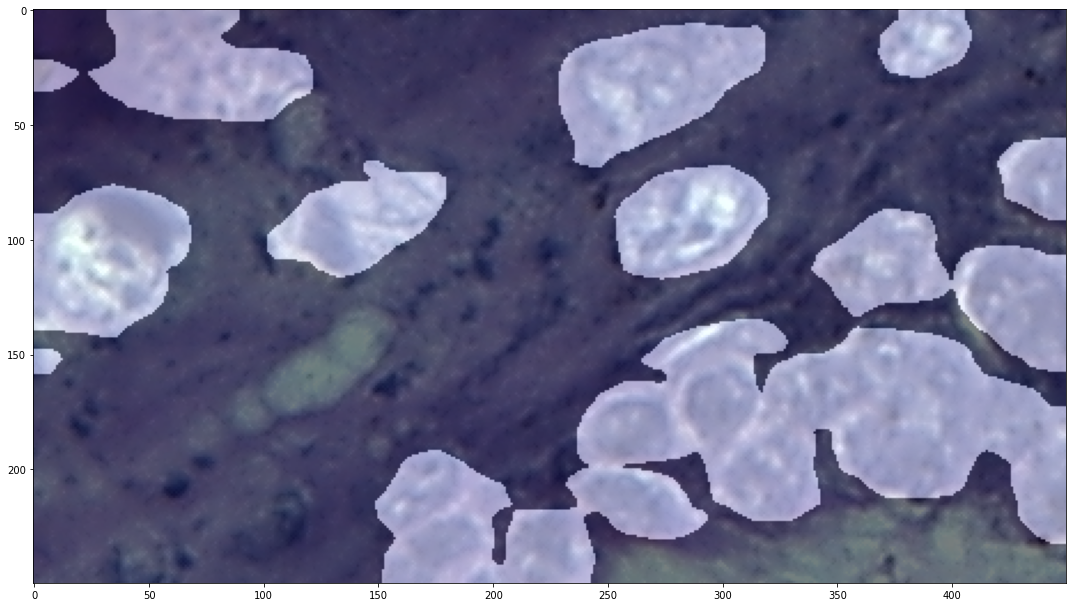

In [16]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image003-2-roi1.tif')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

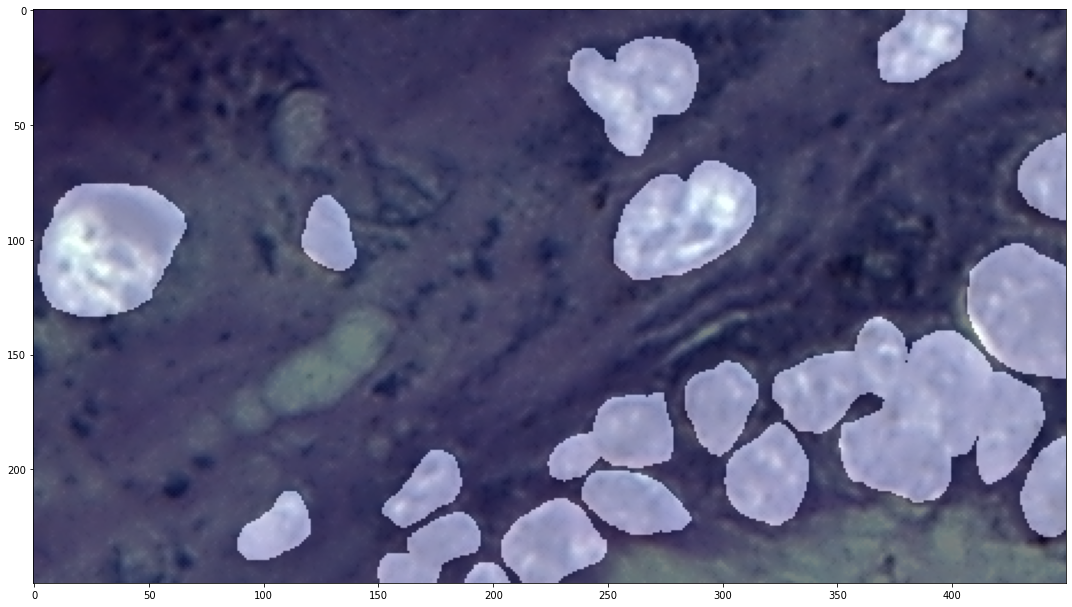

In [17]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image003-2-roi1.tif')
result = mmcv.imread('ToTrain/annotations/image003-2-roi1.tif',flag='grayscale')

model.cfg = cfg
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

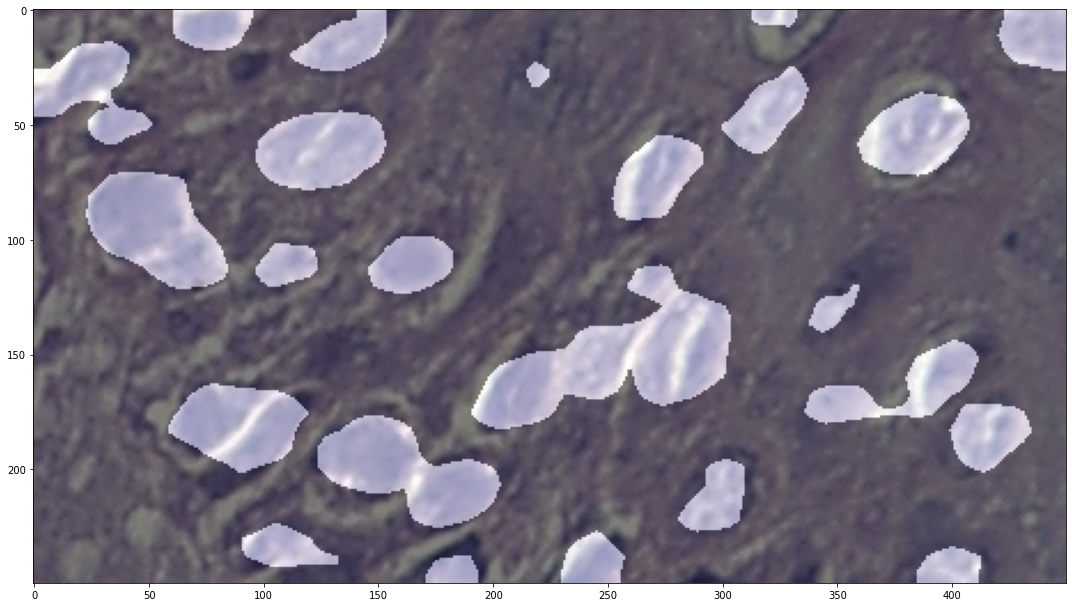

In [18]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image037-roi4.tif')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

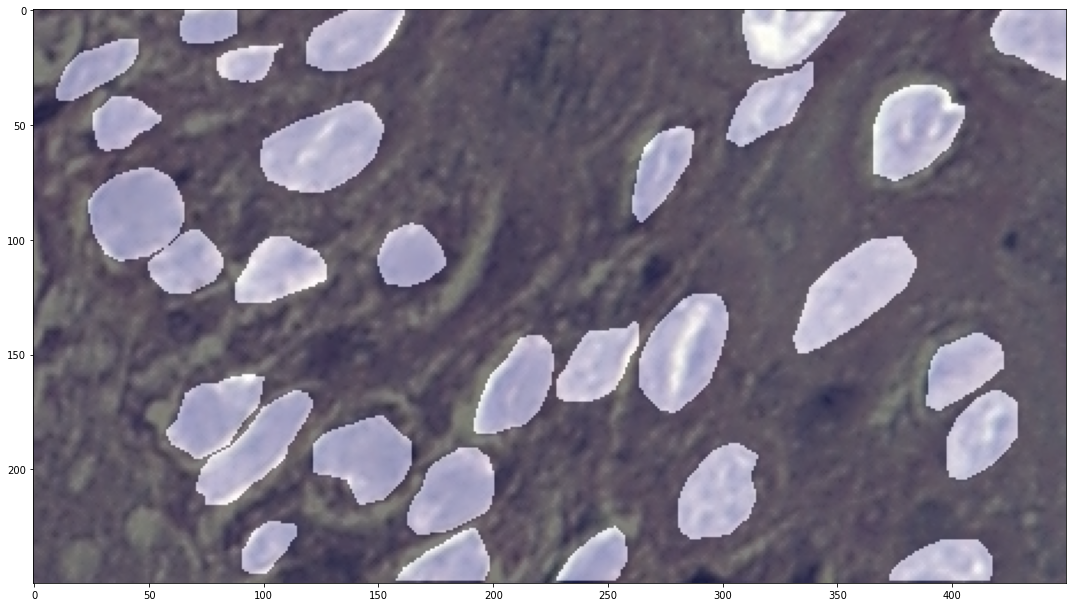

In [19]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image037-roi4.tif')
result = mmcv.imread('ToTrain/annotations/image037-roi4.tif',flag='grayscale')

model.cfg = cfg
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

In [20]:
!rm -rf segmentation
!unzip ../../segmentation.zip

Archive:  ../../segmentation.zip
   creating: segmentation/
   creating: segmentation/annotations/
   creating: segmentation/annotations/healthy/
  inflating: segmentation/annotations/healthy/image003-2-roi2.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi3.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi4.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi5.tif  
  inflating: segmentation/annotations/healthy/image004-roi1.tif  
  inflating: segmentation/annotations/healthy/image004-roi2.tif  
  inflating: segmentation/annotations/healthy/image004-roi3.tif  
  inflating: segmentation/annotations/healthy/image004-roi4.tif  
  inflating: segmentation/annotations/healthy/image004-roi5.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi1.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi2.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi3.tif  
  inflating: segmentation/annotations/healthy/im

In [21]:
from glob import glob
classes = ['healthy', 'mild', 'moderate', 'severe']
train_images = []
for dysplasia in classes:
    images_glob = glob(f'segmentation/images/{dysplasia}/*')
    for img_path in images_glob:
        img = mmcv.imread(img_path)
        train_images.append((img, f'./work_dirs/psp/raw_res/' + img_path[20:]))

In [22]:
%rm -rf ./work_dirs/psp/raw_res/

In [23]:
%mkdir ./work_dirs/psp/raw_res/
%mkdir ./work_dirs/psp/raw_res/healthy
%mkdir ./work_dirs/psp/raw_res/mild
%mkdir ./work_dirs/psp/raw_res/moderate
%mkdir ./work_dirs/psp/raw_res/severe

In [24]:
import cv2 as cv
opacity = 0.5
fig_size=(15, 10)
for img, path in train_images:
  model.cfg = cfg
  result = inference_segmentor(model, img)
  predict_img = result[0]
  predict_img[predict_img == 1] = 255
  predict_img[predict_img == 0] = 0
  cv.imwrite(f'{path}', predict_img)

In [25]:
%matplotlib inline
import json

file = open('./work_dirs/psp/None.log.json')
lines = file.readlines()

m_dice = []
m_acc = []
loss = []

for line in lines:
    json_line = json.loads(line)
    if len(json_line):
        if json_line['mode'] == 'train':
            loss.append(json_line['loss'])
        else:
            m_acc.append(json_line['mAcc'])
            m_dice.append(json_line['mDice'])

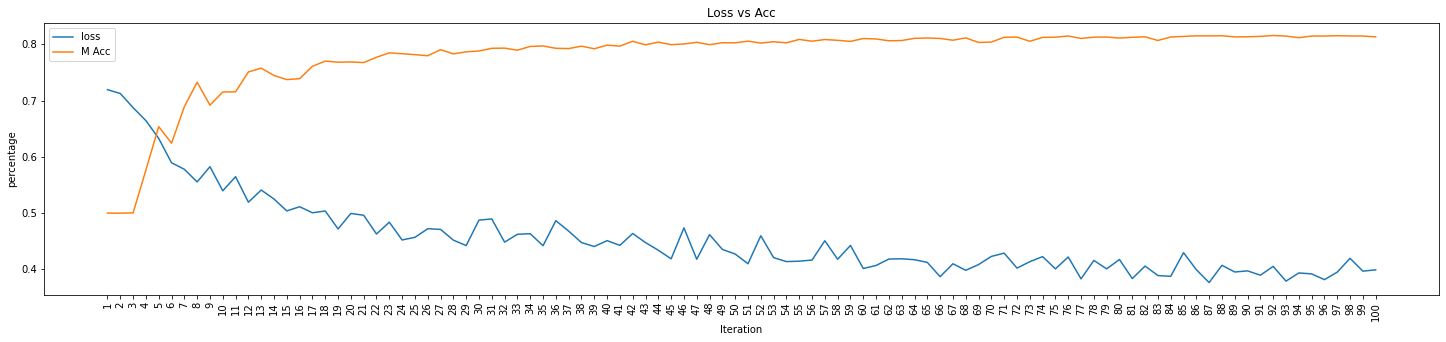

In [34]:
plt.figure(figsize=(25, 5))
plt.plot(range(1, len(m_acc) + 1), loss, label="loss")
plt.plot(range(1, len(m_acc) + 1), m_acc, label="M Acc")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("Loss vs Acc")
plt.xlabel("Iteration")
plt.ylabel("percentage")
plt.legend()
plt.savefig('./work_dirs/psp/Loss_vs_Acc_Graph.png')
plt.show()

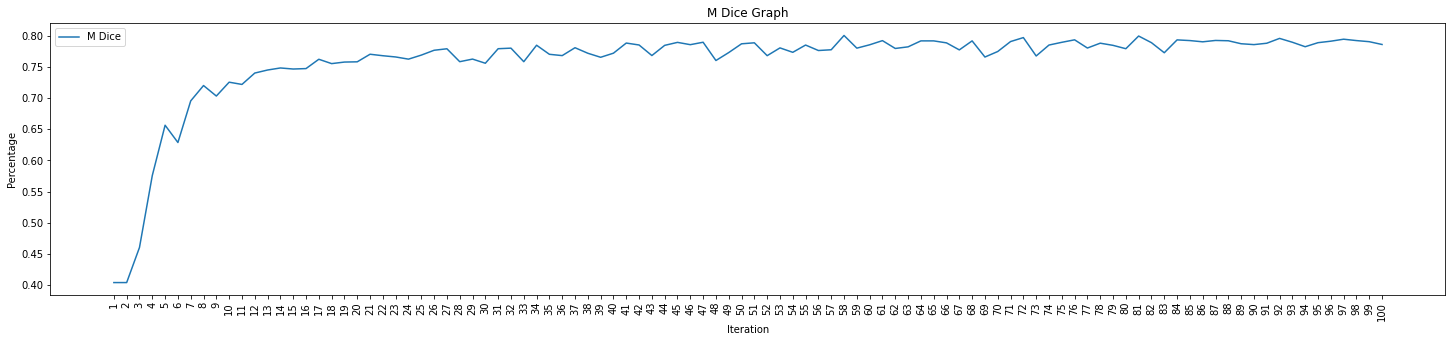

In [35]:
plt.figure(figsize=(25, 5))
plt.plot(range(1, len(m_acc) + 1), m_dice, label="M Dice")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("M Dice Graph")
plt.xlabel("Iteration")
plt.ylabel("Percentage")
plt.legend()
plt.savefig('./work_dirs/psp/M_Dice_Graph.png')
plt.show()
plt.close()

In [36]:
!zip -r pspNet_100.zip ./work_dirs/psp/

updating: work_dirs/psp/ (stored 0%)
updating: work_dirs/psp/epoch_10.pth (deflated 8%)
updating: work_dirs/psp/epoch_60.pth (deflated 8%)
updating: work_dirs/psp/epoch_70.pth (deflated 8%)
updating: work_dirs/psp/epoch_50.pth (deflated 8%)
updating: work_dirs/psp/epoch_20.pth (deflated 8%)
updating: work_dirs/psp/raw_res/ (stored 0%)
updating: work_dirs/psp/raw_res/mild/ (stored 0%)
updating: work_dirs/psp/raw_res/mild/image018-roi6.tif (deflated 3%)
updating: work_dirs/psp/raw_res/mild/image018-roi3.tif (deflated 3%)
updating: work_dirs/psp/raw_res/mild/image006-roi1.tif (deflated 4%)
updating: work_dirs/psp/raw_res/mild/image008-roi1.tif (deflated 9%)
updating: work_dirs/psp/raw_res/mild/image021-roi6.tif (deflated 4%)
updating: work_dirs/psp/raw_res/mild/image008-roi3.tif (deflated 8%)
updating: work_dirs/psp/raw_res/mild/image021-roi5.tif (deflated 5%)
updating: work_dirs/psp/raw_res/mild/image006-roi5.tif (deflated 4%)
updating: work_dirs/psp/raw_res/mild/image006-roi3.tif (defla

In [29]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
#!cp pspNet_150.zip /content/drive/MyDrive/TCC/